In [1]:
# 1

###### 18 September 2023 #########
# In this notebook, I am making a comparison between the
# co-add spectrum and its constituents for PID 14781,
# which observed a tidal disruption event (TDE)
# and a "new" TDE, which may be the "REPEATOBS"
# that Kate asked me to check out.
#
# Looks like the observations are all STIS,
# with gratings G140L and G230L.
#
# Note that target "tde" has 12 files in the
# "products" directory, while "newtde" has 15 files,
# with the difference being that "newtde" has
# an additional co-add per grating compared to "tde"
# (+1 sg140l, +1 sg230l, +1 sg140L_s230l).
#
# I'll plot up all of the "tde" and "newtde" and see
# how the "REPEATOBS" affects the data quality.
#
# There are 60 base-level constituent spectra overall,
# according to the files I've counted in the directory,
# so I'll need to figure out how many goes into what.


In [2]:
# 2

# Load the relevant packages:

import numpy as np
import matplotlib.pyplot as plt
import scipy
from astropy.io import fits
from scipy import signal
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.stats import chi2_contingency
from sklearn import preprocessing
import pandas as pd
import os

from matplotlib import rc
rc('text', usetex=True)


In [3]:
# 3

# Plot the co-add spectra.
#
# Set the path to the co-add spectrum's directory
# as well as to the files themselves.

coadd_path = '/ifs/archive/dev/processing/hla/home/mburger/hasp/results_2023-09-14/14781/products/'

# Here's the Program-level for "tde" (all gratings):

tde_coadd_file = 'hst_14781_stis_tde_sg140l-sg230l_od82_cspec.fits'

# Here are the "tde" per-grating co-add constituents:

tde_STIS_G140L_const_file = 'hst_14781_stis_tde_sg140l_od82_cspec.fits'
tde_STIS_G230L_const_file = 'hst_14781_stis_tde_sg230l_od82_cspec.fits'

# And here's the Program-level for "newtde" (all gratings):

newtde_coadd_file = 'hst_14781_stis_newtde_sg140l-sg230l_od82_cspec.fits'

# And the "newtde" per-grating co-add constituents:

newtde_STIS_G140L_const_file = 'hst_14781_stis_newtde_sg140l_od82_cspec.fits'
newtde_STIS_G230L_const_file = 'hst_14781_stis_newtde_sg230l_od82_cspec.fits'


These are the constituent files for "tde":  ['od8201010_x1d.fits' 'od8201010_x1d.fits' 'od8201020_x1d.fits'
 'od8201020_x1d.fits' 'od8201030_x1d.fits' 'od8201030_x1d.fits'
 'od8201040_x1d.fits' 'od8201040_x1d.fits']

Number of co-add files:  8

These are the constituent files for "newtde":  ['od8203040_x1d.fits' 'od8203040_x1d.fits' 'od8203050_x1d.fits'
 'od8203050_x1d.fits' 'od8203060_x1d.fits' 'od8203060_x1d.fits'
 'od8204040_x1d.fits' 'od8204040_x1d.fits' 'od8204050_x1d.fits'
 'od8204050_x1d.fits' 'od8204060_x1d.fits' 'od8204060_x1d.fits'
 'od8206080_x1d.fits' 'od8206080_x1d.fits' 'od8206090_x1d.fits'
 'od8206090_x1d.fits' 'od82060a0_x1d.fits' 'od82060a0_x1d.fits'
 'od82060b0_x1d.fits' 'od82060b0_x1d.fits' 'od82060c0_x1d.fits'
 'od82060c0_x1d.fits' 'od82060d0_x1d.fits' 'od82060e0_x1d.fits'
 'od8207080_x1d.fits' 'od8207080_x1d.fits' 'od8207090_x1d.fits'
 'od8207090_x1d.fits' 'od82070a0_x1d.fits' 'od82070a0_x1d.fits'
 'od82070b0_x1d.fits' 'od82070b0_x1d.fits' 'od82070c0_x1d.fits'
 'od

(-3e-15, 9e-15)

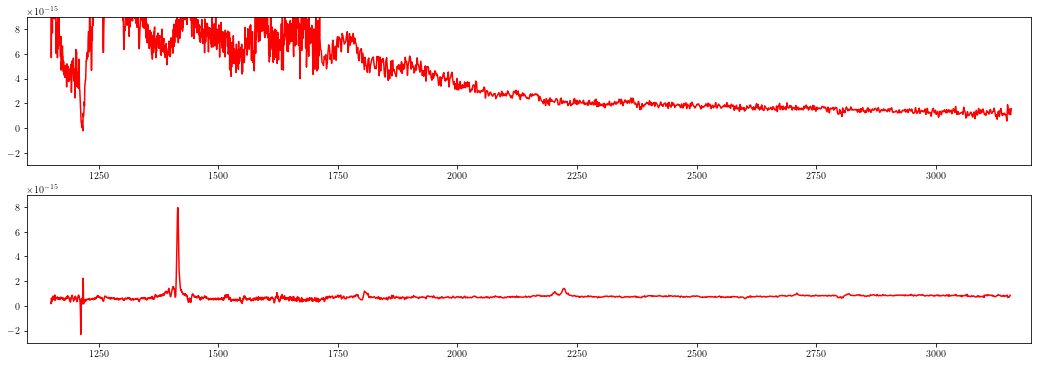

In [4]:
# 4

# First I'll plot the Program-level co-adds for both "tde" and "newtde".

plt.figure(figsize=(18,6))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

# "tde"

table1 = fits.open(coadd_path+tde_coadd_file)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1, color='red')

hdul_1 = fits.open(coadd_path+tde_coadd_file)
x1d_data1 = hdul_1[1].data
x1d_head1 = hdul_1[0].data

x1d_flux1 = x1d_data1['FLUX']
x1d_wave1 = x1d_data1['WAVELENGTH']
x1d_err1 = x1d_data1['ERROR']

coadd_prov = hdul_1[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for "tde": ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

# "newtde"

table2 = fits.open(coadd_path+newtde_coadd_file)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2, color='red')

hdul_2 = fits.open(coadd_path+newtde_coadd_file)
x1d_data2 = hdul_2[1].data
x1d_head2 = hdul_2[0].data

x1d_flux2 = x1d_data2['FLUX']
x1d_wave2 = x1d_data2['WAVELENGTH']
x1d_err2 = x1d_data2['ERROR']

coadd_prov = hdul_2[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for "newtde": ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

# Set appropriate scales.

ax1.set_xlim(1100, 3200)
#ax1.set_ylim(-0.2e-14, 1.8e-14)
ax1.set_ylim(-3.0e-15, 9.0e-15)

ax2.set_xlim(1100, 3200)
ax2.set_ylim(-3.0e-15, 9.0e-15)


These are the constituent files for "tde" G140L:  ['od8201010_x1d.fits' 'od8201010_x1d.fits' 'od8201020_x1d.fits'
 'od8201020_x1d.fits']

Number of co-add files:  4

These are the constituent files for "tde" G230L:  ['od8201030_x1d.fits' 'od8201030_x1d.fits' 'od8201040_x1d.fits'
 'od8201040_x1d.fits']

Number of co-add files:  4



(-2e-15, 1.8e-14)

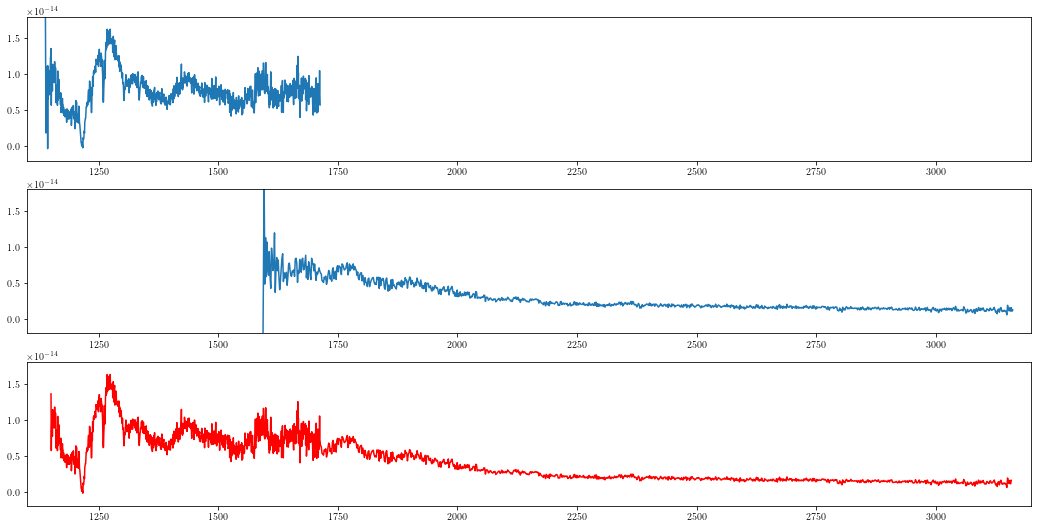

In [5]:
# 5

# Next, let's look at the per-grating co-adds on the same scale(s).
# ("tde" first, then "newtde")

plt.figure(figsize=(18,9))

ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

# "tde" STIS G140L

table1 = fits.open(coadd_path+tde_STIS_G140L_const_file)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1)

hdul_1 = fits.open(coadd_path+tde_STIS_G140L_const_file)
x1d_data1 = hdul_1[1].data
x1d_head1 = hdul_1[0].data

x1d_flux1 = x1d_data1['FLUX']
x1d_wave1 = x1d_data1['WAVELENGTH']
x1d_err1 = x1d_data1['ERROR']

coadd_prov = hdul_1[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for "tde" G140L: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

# "tde" STIS G230L

table2 = fits.open(coadd_path+tde_STIS_G230L_const_file)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2)

hdul_2 = fits.open(coadd_path+tde_STIS_G230L_const_file)
x1d_data2 = hdul_2[1].data
x1d_head2 = hdul_2[0].data

x1d_flux2 = x1d_data2['FLUX']
x1d_wave2 = x1d_data2['WAVELENGTH']
x1d_err2 = x1d_data2['ERROR']

coadd_prov = hdul_2[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for "tde" G230L: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

# "tde" Program-level co-add

table3 = fits.open(coadd_path+tde_coadd_file)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3, color='red')
    
# Set appropriate scales.

ax1.set_xlim(1100, 3200)
ax1.set_ylim(-0.2e-14, 1.8e-14)

ax2.set_xlim(1100, 3200)
ax2.set_ylim(-0.2e-14, 1.8e-14)

ax3.set_xlim(1100, 3200)
ax3.set_ylim(-0.2e-14, 1.8e-14)


These are the constituent files for "newtde" G140L:  ['od8203040_x1d.fits' 'od8203040_x1d.fits' 'od8203050_x1d.fits'
 'od8203050_x1d.fits' 'od8203060_x1d.fits' 'od8203060_x1d.fits'
 'od8204040_x1d.fits' 'od8204040_x1d.fits' 'od8204050_x1d.fits'
 'od8204050_x1d.fits' 'od8204060_x1d.fits' 'od8204060_x1d.fits'
 'od8206080_x1d.fits' 'od8206080_x1d.fits' 'od8206090_x1d.fits'
 'od8206090_x1d.fits' 'od82060a0_x1d.fits' 'od82060a0_x1d.fits'
 'od82060b0_x1d.fits' 'od82060b0_x1d.fits' 'od82060c0_x1d.fits'
 'od82060c0_x1d.fits' 'od82060d0_x1d.fits' 'od82060e0_x1d.fits'
 'od8207080_x1d.fits' 'od8207080_x1d.fits' 'od8207090_x1d.fits'
 'od8207090_x1d.fits' 'od82070a0_x1d.fits' 'od82070a0_x1d.fits'
 'od82070b0_x1d.fits' 'od82070b0_x1d.fits' 'od82070c0_x1d.fits'
 'od82070c0_x1d.fits' 'od82070d0_x1d.fits' 'od82070e0_x1d.fits']

Number of co-add files:  36

These are the constituent files for "newtde" G230L:  ['od8203010_x1d.fits' 'od8203010_x1d.fits' 'od8203020_x1d.fits'
 'od8203020_x1d.fits' 'od820303

(-3e-15, 9e-15)

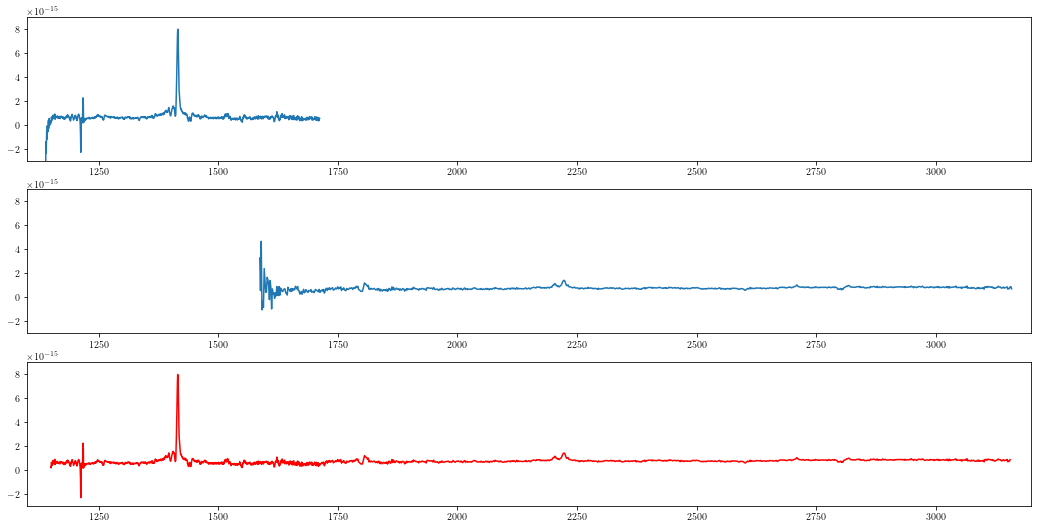

In [6]:
# 6

plt.figure(figsize=(18,9))

# Let's continue looking at the per-grating co-adds on the same scale(s).

ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

# "newtde" STIS G140L

table1 = fits.open(coadd_path+newtde_STIS_G140L_const_file)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1)

hdul_1 = fits.open(coadd_path+newtde_STIS_G140L_const_file)
x1d_data1 = hdul_1[1].data
x1d_head1 = hdul_1[0].data

x1d_flux1 = x1d_data1['FLUX']
x1d_wave1 = x1d_data1['WAVELENGTH']
x1d_err1 = x1d_data1['ERROR']

coadd_prov = hdul_1[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for "newtde" G140L: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

# "newtde" STIS G230L

table2 = fits.open(coadd_path+newtde_STIS_G230L_const_file)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2)

hdul_2 = fits.open(coadd_path+newtde_STIS_G230L_const_file)
x1d_data2 = hdul_2[1].data
x1d_head2 = hdul_2[0].data

x1d_flux2 = x1d_data2['FLUX']
x1d_wave2 = x1d_data2['WAVELENGTH']
x1d_err2 = x1d_data2['ERROR']

coadd_prov = hdul_2[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for "newtde" G230L: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

# "newtde" Program-level co-add

table3 = fits.open(coadd_path+newtde_coadd_file)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3, color='red')
    
# Set appropriate scales.

ax1.set_xlim(1100, 3200)
ax1.set_ylim(-3.0e-15, 9.0e-15)

ax2.set_xlim(1100, 3200)
ax2.set_ylim(-3.0e-15, 9.0e-15)

ax3.set_xlim(1100, 3200)
ax3.set_ylim(-3.0e-15, 9.0e-15)


In [7]:
# 7

# As we learned from the last two cells, each of the STIS co-added
# spectra is made up of 4 ("tde") or 36 ("newtde") base-level
# constituent spectra, though it looks like in reality it's half,
# since every base-level constituent spectrum is listed twice.
#
# Actually that's only partly true for "newtde", where I've found
# that the base-level constituents listed repeat in all but four cases.
#
# Not sure what's up with that, but I'll ask and get to the bottom of it.
#
# "tde"
#
# G140L: 'od8201010_x1d.fits' 'od8201010_x1d.fits'
#        'od8201020_x1d.fits' 'od8201020_x1d.fits'
#
# G230L: 'od8201030_x1d.fits' 'od8201030_x1d.fits'
#        'od8201040_x1d.fits' 'od8201040_x1d.fits'
#
# "newtde"
#
# G140L: 'od8203040_x1d.fits' 'od8203040_x1d.fits' 'od8203050_x1d.fits'
#        'od8203050_x1d.fits' 'od8203060_x1d.fits' 'od8203060_x1d.fits'
#        'od8204040_x1d.fits' 'od8204040_x1d.fits' 'od8204050_x1d.fits'
#        'od8204050_x1d.fits' 'od8204060_x1d.fits' 'od8204060_x1d.fits'
#        'od8206080_x1d.fits' 'od8206080_x1d.fits' 'od8206090_x1d.fits'
#        'od8206090_x1d.fits' 'od82060a0_x1d.fits' 'od82060a0_x1d.fits'
#        'od82060b0_x1d.fits' 'od82060b0_x1d.fits' 'od82060c0_x1d.fits'
#        'od82060c0_x1d.fits' 'od82060d0_x1d.fits' 'od82060e0_x1d.fits'
#        'od8207080_x1d.fits' 'od8207080_x1d.fits' 'od8207090_x1d.fits'
#        'od8207090_x1d.fits' 'od82070a0_x1d.fits' 'od82070a0_x1d.fits'
#        'od82070b0_x1d.fits' 'od82070b0_x1d.fits' 'od82070c0_x1d.fits'
#        'od82070c0_x1d.fits' 'od82070d0_x1d.fits' 'od82070e0_x1d.fits'
#
# G230L: 'od8203010_x1d.fits' 'od8203010_x1d.fits' 'od8203020_x1d.fits'
#        'od8203020_x1d.fits' 'od8203030_x1d.fits' 'od8203030_x1d.fits'
#        'od8204010_x1d.fits' 'od8204010_x1d.fits' 'od8204020_x1d.fits'
#        'od8204020_x1d.fits' 'od8204030_x1d.fits' 'od8204030_x1d.fits'
#        'od8206010_x1d.fits' 'od8206010_x1d.fits' 'od8206020_x1d.fits'
#        'od8206020_x1d.fits' 'od8206030_x1d.fits' 'od8206030_x1d.fits'
#        'od8206040_x1d.fits' 'od8206040_x1d.fits' 'od8206050_x1d.fits'
#        'od8206050_x1d.fits' 'od8206060_x1d.fits' 'od8206070_x1d.fits'
#        'od8207010_x1d.fits' 'od8207010_x1d.fits' 'od8207020_x1d.fits'
#        'od8207020_x1d.fits' 'od8207030_x1d.fits' 'od8207030_x1d.fits'
#        'od8207040_x1d.fits' 'od8207040_x1d.fits' 'od8207050_x1d.fits'
#        'od8207050_x1d.fits' 'od8207060_x1d.fits' 'od8207070_x1d.fits'
#
# By examining the '/products/' directory for PID 16196,
# we can see how many co-adds there are per-grating.
#
# # "tde"
#
# For G140L, there are three:
#
# hst_14781_stis_tde_sg140l_od8201_cspec.fits
# hst_14781_stis_tde_sg140l_od8202_cspec.fits
# hst_14781_stis_tde_sg140l_od8205_cspec.fits
#
# For G230L, there are three:
#
# hst_14781_stis_tde_sg230l_od8201_cspec.fits
# hst_14781_stis_tde_sg230l_od8202_cspec.fits
# hst_14781_stis_tde_sg230l_od8205_cspec.fits
#
# "newtde"
#
# For G140L, there are four:
#
# hst_14781_stis_newtde_sg140l_od8203_cspec.fits
# hst_14781_stis_newtde_sg140l_od8204_cspec.fits
# hst_14781_stis_newtde_sg140l_od8206_cspec.fits
# hst_14781_stis_newtde_sg140l_od8207_cspec.fits
#
# For G230L, there are four:
#
# hst_14781_stis_newtde_sg230l_od8203_cspec.fits
# hst_14781_stis_newtde_sg230l_od8204_cspec.fits
# hst_14781_stis_newtde_sg230l_od8206_cspec.fits
# hst_14781_stis_newtde_sg230l_od8207_cspec.fits
#
# Let's identify the constituent co-add files:

# "tde"

tde_STIS_G140L_const_file1 = 'hst_14781_stis_tde_sg140l_od8201_cspec.fits'
tde_STIS_G140L_const_file2 = 'hst_14781_stis_tde_sg140l_od8202_cspec.fits'
tde_STIS_G140L_const_file3 = 'hst_14781_stis_tde_sg140l_od8205_cspec.fits'

tde_STIS_G230L_const_file1 = 'hst_14781_stis_tde_sg230l_od8201_cspec.fits'
tde_STIS_G230L_const_file2 = 'hst_14781_stis_tde_sg230l_od8202_cspec.fits'
tde_STIS_G230L_const_file3 = 'hst_14781_stis_tde_sg230l_od8205_cspec.fits'

# "newtde"

newtde_STIS_G140L_const_file1 = 'hst_14781_stis_newtde_sg140l_od8203_cspec.fits'
newtde_STIS_G140L_const_file2 = 'hst_14781_stis_newtde_sg140l_od8204_cspec.fits'
newtde_STIS_G140L_const_file3 = 'hst_14781_stis_newtde_sg140l_od8206_cspec.fits'
newtde_STIS_G140L_const_file4 = 'hst_14781_stis_newtde_sg140l_od8207_cspec.fits'

newtde_STIS_G230L_const_file1 = 'hst_14781_stis_newtde_sg230l_od8203_cspec.fits'
newtde_STIS_G230L_const_file2 = 'hst_14781_stis_newtde_sg230l_od8204_cspec.fits'
newtde_STIS_G230L_const_file3 = 'hst_14781_stis_newtde_sg230l_od8206_cspec.fits'
newtde_STIS_G230L_const_file4 = 'hst_14781_stis_newtde_sg230l_od8207_cspec.fits'


In [8]:
# 8

# Let's figure out what base-level constituent spectra go into
# each of the per-grating co-add files:

# "tde"

# STIS G140L

hdul_1 = fits.open(coadd_path+tde_STIS_G140L_const_file1)
x1d_data1 = hdul_1[1].data
x1d_head1 = hdul_1[0].data

x1d_flux1 = x1d_data1['FLUX']
x1d_wave1 = x1d_data1['WAVELENGTH']
x1d_err1 = x1d_data1['ERROR']

coadd_prov = hdul_1[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for tde STIS G140L_1: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

hdul_2 = fits.open(coadd_path+tde_STIS_G140L_const_file2)
x1d_data2 = hdul_2[1].data
x1d_head2 = hdul_2[0].data

x1d_flux2 = x1d_data2['FLUX']
x1d_wave2 = x1d_data2['WAVELENGTH']
x1d_err2 = x1d_data2['ERROR']

coadd_prov = hdul_2[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for tde STIS G140L_2: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

hdul_3 = fits.open(coadd_path+tde_STIS_G140L_const_file3)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for tde STIS G140L_3: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

# STIS G230L

hdul_1 = fits.open(coadd_path+tde_STIS_G230L_const_file1)
x1d_data1 = hdul_1[1].data
x1d_head1 = hdul_1[0].data

x1d_flux1 = x1d_data1['FLUX']
x1d_wave1 = x1d_data1['WAVELENGTH']
x1d_err1 = x1d_data1['ERROR']

coadd_prov = hdul_1[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for tde STIS G230L_1: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

hdul_2 = fits.open(coadd_path+tde_STIS_G230L_const_file2)
x1d_data2 = hdul_2[1].data
x1d_head2 = hdul_2[0].data

x1d_flux2 = x1d_data2['FLUX']
x1d_wave2 = x1d_data2['WAVELENGTH']
x1d_err2 = x1d_data2['ERROR']

coadd_prov = hdul_2[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for tde STIS G230L_2: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

hdul_3 = fits.open(coadd_path+tde_STIS_G230L_const_file3)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for tde STIS G230L_3: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')


These are the constituent files for tde STIS G140L_1:  ['od8201010_x1d.fits' 'od8201010_x1d.fits' 'od8201020_x1d.fits'
 'od8201020_x1d.fits']

Number of co-add files:  4

These are the constituent files for tde STIS G140L_2:  ['od8202010_x1d.fits' 'od8202010_x1d.fits' 'od8202020_x1d.fits'
 'od8202020_x1d.fits' 'od8202030_x1d.fits' 'od8202030_x1d.fits']

Number of co-add files:  6

These are the constituent files for tde STIS G140L_3:  ['od8205010_x1d.fits' 'od8205010_x1d.fits' 'od8205020_x1d.fits'
 'od8205020_x1d.fits' 'od8205030_x1d.fits' 'od8205030_x1d.fits'
 'od8205040_x1d.fits' 'od8205040_x1d.fits' 'od8205050_x1d.fits'
 'od8205050_x1d.fits']

Number of co-add files:  10

These are the constituent files for tde STIS G230L_1:  ['od8201030_x1d.fits' 'od8201030_x1d.fits' 'od8201040_x1d.fits'
 'od8201040_x1d.fits']

Number of co-add files:  4

These are the constituent files for tde STIS G230L_2:  ['od8202040_x1d.fits' 'od8202040_x1d.fits' 'od8202050_x1d.fits'
 'od8202050_x1d.fits' 'od8

In [9]:
# 9

# Let's figure out what base-level constituent spectra go into
# each of the per-grating co-add files:

# "newtde"

# STIS G140L

hdul_1 = fits.open(coadd_path+newtde_STIS_G140L_const_file1)
x1d_data1 = hdul_1[1].data
x1d_head1 = hdul_1[0].data

x1d_flux1 = x1d_data1['FLUX']
x1d_wave1 = x1d_data1['WAVELENGTH']
x1d_err1 = x1d_data1['ERROR']

coadd_prov = hdul_1[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for newtde STIS G140L_1: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

hdul_2 = fits.open(coadd_path+newtde_STIS_G140L_const_file2)
x1d_data2 = hdul_2[1].data
x1d_head2 = hdul_2[0].data

x1d_flux2 = x1d_data2['FLUX']
x1d_wave2 = x1d_data2['WAVELENGTH']
x1d_err2 = x1d_data2['ERROR']

coadd_prov = hdul_2[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for newtde STIS G140L_2: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

hdul_3 = fits.open(coadd_path+newtde_STIS_G140L_const_file3)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for newtde STIS G140L_3: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

hdul_4 = fits.open(coadd_path+newtde_STIS_G140L_const_file4)
x1d_data4 = hdul_4[1].data
x1d_head4 = hdul_4[0].data

x1d_flux4 = x1d_data4['FLUX']
x1d_wave4 = x1d_data4['WAVELENGTH']
x1d_err4 = x1d_data4['ERROR']

coadd_prov = hdul_4[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for newtde STIS G140L_4: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

# STIS G230L

hdul_1 = fits.open(coadd_path+newtde_STIS_G230L_const_file1)
x1d_data1 = hdul_1[1].data
x1d_head1 = hdul_1[0].data

x1d_flux1 = x1d_data1['FLUX']
x1d_wave1 = x1d_data1['WAVELENGTH']
x1d_err1 = x1d_data1['ERROR']

coadd_prov = hdul_1[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for newtde STIS G230L_1: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

hdul_2 = fits.open(coadd_path+newtde_STIS_G230L_const_file2)
x1d_data2 = hdul_2[1].data
x1d_head2 = hdul_2[0].data

x1d_flux2 = x1d_data2['FLUX']
x1d_wave2 = x1d_data2['WAVELENGTH']
x1d_err2 = x1d_data2['ERROR']

coadd_prov = hdul_2[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for newtde STIS G230L_2: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

hdul_3 = fits.open(coadd_path+newtde_STIS_G230L_const_file3)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for newtde STIS G230L_3: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

hdul_4 = fits.open(coadd_path+newtde_STIS_G230L_const_file4)
x1d_data4 = hdul_4[1].data
x1d_head4 = hdul_4[0].data

x1d_flux4 = x1d_data4['FLUX']
x1d_wave4 = x1d_data4['WAVELENGTH']
x1d_err4 = x1d_data4['ERROR']

coadd_prov = hdul_4[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for newtde STIS G230L_4: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')


These are the constituent files for newtde STIS G140L_1:  ['od8203040_x1d.fits' 'od8203040_x1d.fits' 'od8203050_x1d.fits'
 'od8203050_x1d.fits' 'od8203060_x1d.fits' 'od8203060_x1d.fits']

Number of co-add files:  6

These are the constituent files for newtde STIS G140L_2:  ['od8204040_x1d.fits' 'od8204040_x1d.fits' 'od8204050_x1d.fits'
 'od8204050_x1d.fits' 'od8204060_x1d.fits' 'od8204060_x1d.fits']

Number of co-add files:  6

These are the constituent files for newtde STIS G140L_3:  ['od8206080_x1d.fits' 'od8206080_x1d.fits' 'od8206090_x1d.fits'
 'od8206090_x1d.fits' 'od82060a0_x1d.fits' 'od82060a0_x1d.fits'
 'od82060b0_x1d.fits' 'od82060b0_x1d.fits' 'od82060c0_x1d.fits'
 'od82060c0_x1d.fits' 'od82060d0_x1d.fits' 'od82060e0_x1d.fits']

Number of co-add files:  12

These are the constituent files for newtde STIS G140L_4:  ['od8207080_x1d.fits' 'od8207080_x1d.fits' 'od8207090_x1d.fits'
 'od8207090_x1d.fits' 'od82070a0_x1d.fits' 'od82070a0_x1d.fits'
 'od82070b0_x1d.fits' 'od82070b0_x1d.

In [10]:
# 10

# Let's look at the base-level STIS constituent spectra.

base_path = '/ifs/archive/dev/processing/hla/home/mburger/hasp/results_2023-09-14/14781/'

# "tde"

'''
These are the constituent files for tde STIS G140L_1:  ['od8201010_x1d.fits' 'od8201010_x1d.fits' 
                                                        'od8201020_x1d.fits' 'od8201020_x1d.fits']

These are the constituent files for tde STIS G140L_2:  ['od8202010_x1d.fits' 'od8202010_x1d.fits' 
                                                        'od8202020_x1d.fits' 'od8202020_x1d.fits' 
                                                        'od8202030_x1d.fits' 'od8202030_x1d.fits']

These are the constituent files for tde STIS G140L_3:  ['od8205010_x1d.fits' 'od8205010_x1d.fits' 
                                                        'od8205020_x1d.fits' 'od8205020_x1d.fits' 
                                                        'od8205030_x1d.fits' 'od8205030_x1d.fits'
                                                        'od8205040_x1d.fits' 'od8205040_x1d.fits'
                                                        'od8205050_x1d.fits' 'od8205050_x1d.fits']

These are the constituent files for tde STIS G230L_1:  ['od8201030_x1d.fits' 'od8201030_x1d.fits' 
                                                        'od8201040_x1d.fits' 'od8201040_x1d.fits']

These are the constituent files for tde STIS G230L_2:  ['od8202040_x1d.fits' 'od8202040_x1d.fits'
                                                        'od8202050_x1d.fits' 'od8202050_x1d.fits'
                                                        'od8202060_x1d.fits' 'od8202060_x1d.fits']

These are the constituent files for tde STIS G230L_3:  ['od8205060_x1d.fits' 'od8205060_x1d.fits'
                                                        'od8205070_x1d.fits' 'od8205070_x1d.fits'
                                                        'od8205080_x1d.fits' 'od8205080_x1d.fits'
                                                        'od8205090_x1d.fits' 'od8205090_x1d.fits'
                                                        'od82050a0_x1d.fits' 'od82050a0_x1d.fits']
'''

# "tde" STIS G140L

tde_STIS_G140L_base_file01 = 'od8201010_x1d.fits'
tde_STIS_G140L_base_file02 = 'od8201020_x1d.fits'
tde_STIS_G140L_base_file03 = 'od8202010_x1d.fits'
tde_STIS_G140L_base_file04 = 'od8202020_x1d.fits'
tde_STIS_G140L_base_file05 = 'od8202030_x1d.fits'
tde_STIS_G140L_base_file06 = 'od8205010_x1d.fits'
tde_STIS_G140L_base_file07 = 'od8205020_x1d.fits'
tde_STIS_G140L_base_file08 = 'od8205030_x1d.fits'
tde_STIS_G140L_base_file09 = 'od8205040_x1d.fits'
tde_STIS_G140L_base_file10 = 'od8205050_x1d.fits'

# "tde" STIS G230L

tde_STIS_G230L_base_file01 = 'od8201030_x1d.fits'
tde_STIS_G230L_base_file02 = 'od8201040_x1d.fits'
tde_STIS_G230L_base_file03 = 'od8202040_x1d.fits'
tde_STIS_G230L_base_file04 = 'od8202050_x1d.fits'
tde_STIS_G230L_base_file05 = 'od8202060_x1d.fits'
tde_STIS_G230L_base_file06 = 'od8205060_x1d.fits'
tde_STIS_G230L_base_file07 = 'od8205070_x1d.fits'
tde_STIS_G230L_base_file08 = 'od8205080_x1d.fits'
tde_STIS_G230L_base_file09 = 'od8205090_x1d.fits'
tde_STIS_G230L_base_file10 = 'od82050a0_x1d.fits'

# Note that despite there being 20 base-level constituent files, each one
# appears to be used twice, making 10 total for each grating.


In [11]:
# 11

# "newtde"

'''
These are the constituent files for newtde STIS G140L_1:  ['od8203040_x1d.fits' 'od8203040_x1d.fits' 
                                                           'od8203050_x1d.fits' 'od8203050_x1d.fits' 
                                                           'od8203060_x1d.fits' 'od8203060_x1d.fits']

These are the constituent files for newtde STIS G140L_2:  ['od8204040_x1d.fits' 'od8204040_x1d.fits' 
                                                           'od8204050_x1d.fits' 'od8204050_x1d.fits' 
                                                           'od8204060_x1d.fits' 'od8204060_x1d.fits']

These are the constituent files for newtde STIS G140L_3:  ['od8206080_x1d.fits' 'od8206080_x1d.fits' 
                                                           'od8206090_x1d.fits' 'od8206090_x1d.fits' 
                                                           'od82060a0_x1d.fits' 'od82060a0_x1d.fits'
                                                           'od82060b0_x1d.fits' 'od82060b0_x1d.fits' 
                                                           'od82060c0_x1d.fits' 'od82060c0_x1d.fits' 
                                                           'od82060d0_x1d.fits' 'od82060e0_x1d.fits']

These are the constituent files for newtde STIS G140L_4:  ['od8207080_x1d.fits' 'od8207080_x1d.fits'
                                                           'od8207090_x1d.fits' 'od8207090_x1d.fits'
                                                           'od82070a0_x1d.fits' 'od82070a0_x1d.fits'
                                                           'od82070b0_x1d.fits' 'od82070b0_x1d.fits'
                                                           'od82070c0_x1d.fits' 'od82070c0_x1d.fits'
                                                           'od82070d0_x1d.fits' 'od82070e0_x1d.fits']

These are the constituent files for newtde STIS G230L_1:  ['od8203010_x1d.fits' 'od8203010_x1d.fits'
                                                           'od8203020_x1d.fits' 'od8203020_x1d.fits'
                                                           'od8203030_x1d.fits' 'od8203030_x1d.fits']

These are the constituent files for newtde STIS G230L_2:  ['od8204010_x1d.fits' 'od8204010_x1d.fits'
                                                           'od8204020_x1d.fits' 'od8204020_x1d.fits'
                                                           'od8204030_x1d.fits' 'od8204030_x1d.fits']

These are the constituent files for newtde STIS G230L_3:  ['od8206010_x1d.fits' 'od8206010_x1d.fits'
                                                           'od8206020_x1d.fits' 'od8206020_x1d.fits'
                                                           'od8206030_x1d.fits' 'od8206030_x1d.fits'
                                                           'od8206040_x1d.fits' 'od8206040_x1d.fits' 
                                                           'od8206050_x1d.fits' 'od8206050_x1d.fits' 
                                                           'od8206060_x1d.fits' 'od8206070_x1d.fits']

These are the constituent files for newtde STIS G230L_4:  ['od8207010_x1d.fits' 'od8207010_x1d.fits'
                                                           'od8207020_x1d.fits' 'od8207020_x1d.fits' 
                                                           'od8207030_x1d.fits' 'od8207030_x1d.fits'
                                                           'od8207040_x1d.fits' 'od8207040_x1d.fits' 
                                                           'od8207050_x1d.fits' 'od8207050_x1d.fits'
                                                           'od8207060_x1d.fits' 'od8207070_x1d.fits']
'''

# "newtde" STIS G140L

newtde_STIS_G140L_base_file01 = 'od8203040_x1d.fits'
newtde_STIS_G140L_base_file02 = 'od8203050_x1d.fits'
newtde_STIS_G140L_base_file03 = 'od8203060_x1d.fits'
newtde_STIS_G140L_base_file04 = 'od8204040_x1d.fits'
newtde_STIS_G140L_base_file05 = 'od8204050_x1d.fits'
newtde_STIS_G140L_base_file06 = 'od8204060_x1d.fits'
newtde_STIS_G140L_base_file07 = 'od8206080_x1d.fits'
newtde_STIS_G140L_base_file08 = 'od8206090_x1d.fits'
newtde_STIS_G140L_base_file09 = 'od82060a0_x1d.fits'
newtde_STIS_G140L_base_file10 = 'od82060b0_x1d.fits'

newtde_STIS_G140L_base_file11 = 'od82060c0_x1d.fits'
newtde_STIS_G140L_base_file12 = 'od82060d0_x1d.fits'
newtde_STIS_G140L_base_file13 = 'od82060e0_x1d.fits'
newtde_STIS_G140L_base_file14 = 'od8207080_x1d.fits'
newtde_STIS_G140L_base_file15 = 'od8207090_x1d.fits'
newtde_STIS_G140L_base_file16 = 'od82070a0_x1d.fits'
newtde_STIS_G140L_base_file17 = 'od82070b0_x1d.fits'
newtde_STIS_G140L_base_file18 = 'od82070c0_x1d.fits'
newtde_STIS_G140L_base_file19 = 'od82070d0_x1d.fits'
newtde_STIS_G140L_base_file20 = 'od82070e0_x1d.fits'

# "newtde" STIS G230L

newtde_STIS_G230L_base_file01 = 'od8203010_x1d.fits'
newtde_STIS_G230L_base_file02 = 'od8203020_x1d.fits'
newtde_STIS_G230L_base_file03 = 'od8203030_x1d.fits'
newtde_STIS_G230L_base_file04 = 'od8204010_x1d.fits'
newtde_STIS_G230L_base_file05 = 'od8204020_x1d.fits'
newtde_STIS_G230L_base_file06 = 'od8204030_x1d.fits'
newtde_STIS_G230L_base_file07 = 'od8206010_x1d.fits'
newtde_STIS_G230L_base_file08 = 'od8206020_x1d.fits'
newtde_STIS_G230L_base_file09 = 'od8206030_x1d.fits'
newtde_STIS_G230L_base_file10 = 'od8206040_x1d.fits'

newtde_STIS_G230L_base_file11 = 'od8206050_x1d.fits'
newtde_STIS_G230L_base_file12 = 'od8206060_x1d.fits'
newtde_STIS_G230L_base_file13 = 'od8206070_x1d.fits'
newtde_STIS_G230L_base_file14 = 'od8207010_x1d.fits'
newtde_STIS_G230L_base_file15 = 'od8207020_x1d.fits'
newtde_STIS_G230L_base_file16 = 'od8207030_x1d.fits'
newtde_STIS_G230L_base_file17 = 'od8207040_x1d.fits'
newtde_STIS_G230L_base_file18 = 'od8207050_x1d.fits'
newtde_STIS_G230L_base_file19 = 'od8207060_x1d.fits'
newtde_STIS_G230L_base_file20 = 'od8207070_x1d.fits'

# Note that despite there being 36 base-level constituent files, each one
# (besides four each; two each for _3/_4) appears to be used twice, 
# making 20 total for each grating.


(-2e-15, 1.8e-14)

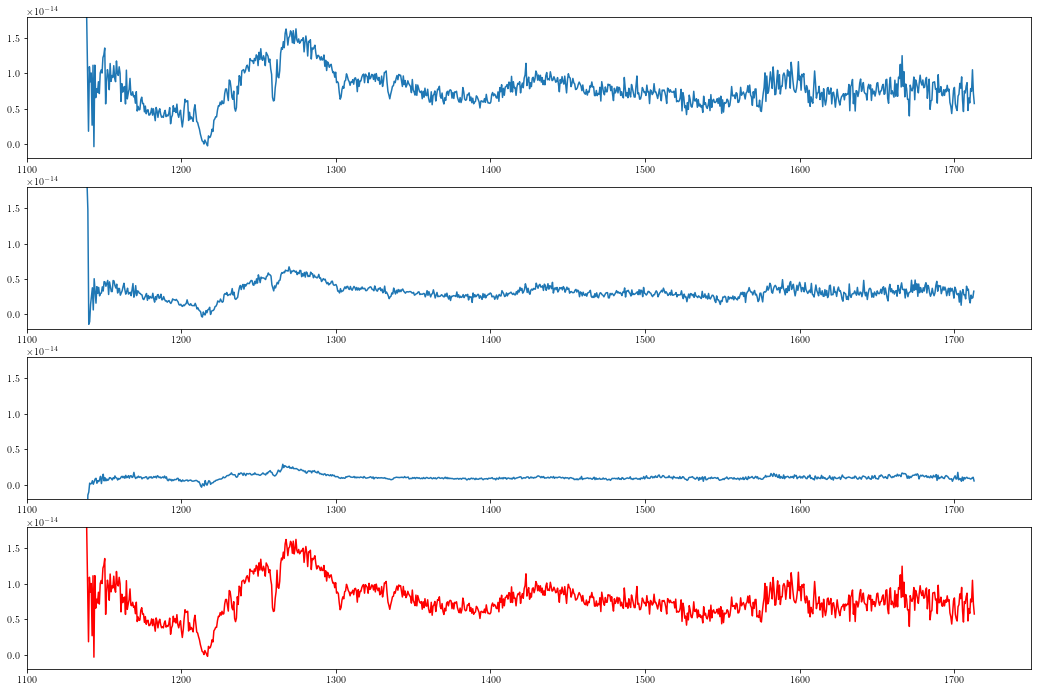

In [12]:
# 12

# Let's plot the per-grating constituents and see how they compare
# with the overall per-grating and program-level co-adds.

# "tde"

# STIS G140L

plt.figure(figsize=(18,12))

ax1 = plt.subplot(411)
ax2 = plt.subplot(412)
ax3 = plt.subplot(413)
ax4 = plt.subplot(414)

table1 = fits.open(coadd_path+tde_STIS_G140L_const_file1)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1)

table2 = fits.open(coadd_path+tde_STIS_G140L_const_file2)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2)

table3 = fits.open(coadd_path+tde_STIS_G140L_const_file3)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(coadd_path+tde_STIS_G140L_const_file)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4, color='red')
    
# Set appropriate scales.

ax1.set_xlim(1100, 1750)
ax1.set_ylim(-0.2e-14, 1.8e-14)

ax2.set_xlim(1100, 1750)
ax2.set_ylim(-0.2e-14, 1.8e-14)

ax3.set_xlim(1100, 1750)
ax3.set_ylim(-0.2e-14, 1.8e-14)

ax4.set_xlim(1100, 1750)
ax4.set_ylim(-0.2e-14, 1.8e-14)


(-2e-15, 1.8e-14)

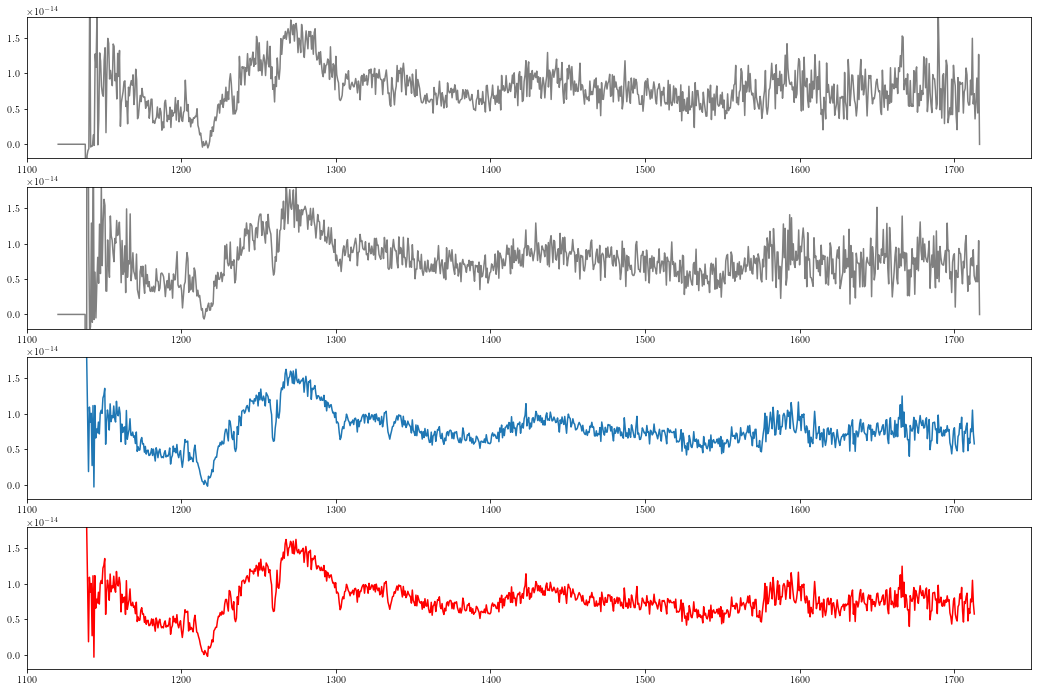

In [13]:
# 13

# Now let's compare the base-level constituent spectra
# with the overall program-level co-add.
#
# "tde"
#
# STIS G140L (1/3)

plt.figure(figsize=(18,12))

ax1 = plt.subplot(411)
ax2 = plt.subplot(412)
ax3 = plt.subplot(413)
ax4 = plt.subplot(414)

table1 = fits.open(base_path+tde_STIS_G140L_base_file01)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1,color='grey')

table2 = fits.open(base_path+tde_STIS_G140L_base_file02)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2,color='grey')

table3 = fits.open(coadd_path+tde_STIS_G140L_const_file1)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(coadd_path+tde_STIS_G140L_const_file)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4,color='red')

# Set appropriate scales.

ax1.set_xlim(1100, 1750)
ax1.set_ylim(-0.2e-14, 1.8e-14)

ax2.set_xlim(1100, 1750)
ax2.set_ylim(-0.2e-14, 1.8e-14)

ax3.set_xlim(1100, 1750)
ax3.set_ylim(-0.2e-14, 1.8e-14)

ax4.set_xlim(1100, 1750)
ax4.set_ylim(-0.2e-14, 1.8e-14)


(-2e-15, 1.8e-14)

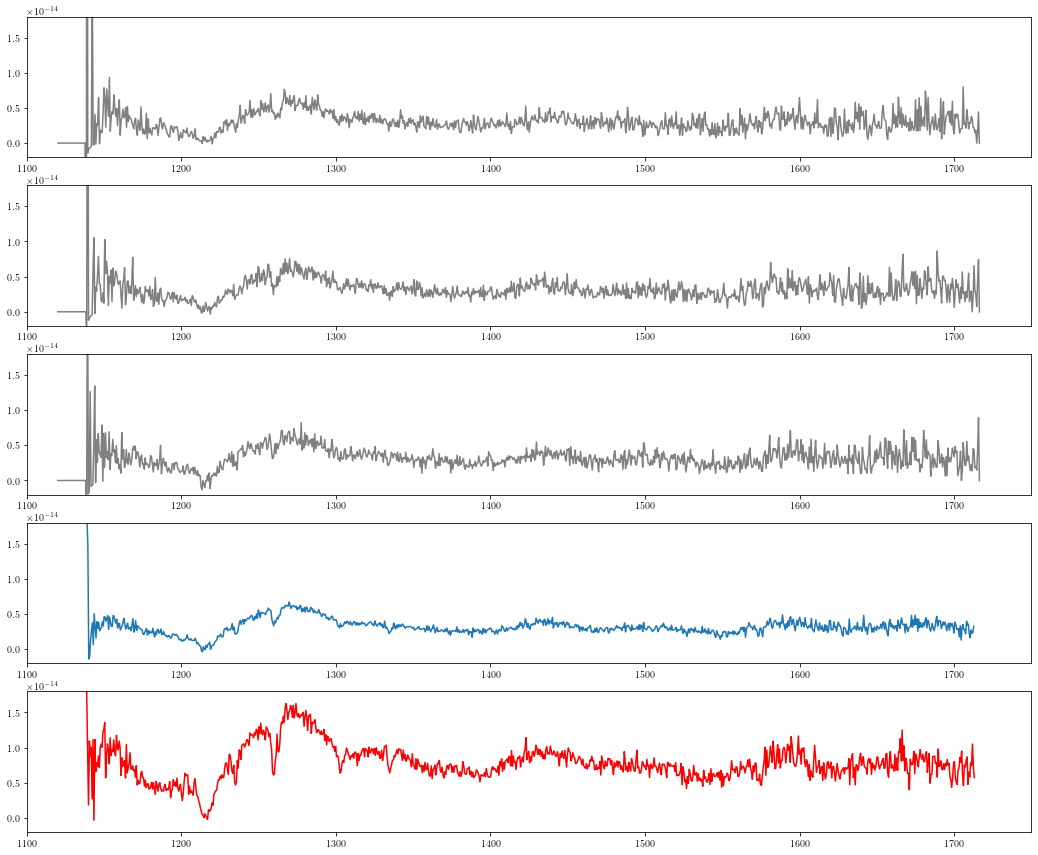

In [14]:
# 14

# Now let's compare the base-level constituent spectra
# with the overall program-level co-add.
#
# "tde"
#
# STIS G140L (2/3)

plt.figure(figsize=(18,15))

ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax5 = plt.subplot(515)

table1 = fits.open(base_path+tde_STIS_G140L_base_file03)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1,color='grey')

table2 = fits.open(base_path+tde_STIS_G140L_base_file04)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2,color='grey')

table3 = fits.open(base_path+tde_STIS_G140L_base_file05)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3,color='grey')

table4 = fits.open(coadd_path+tde_STIS_G140L_const_file2)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(coadd_path+tde_STIS_G140L_const_file)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5,color='red')

# Set appropriate scales.

ax1.set_xlim(1100, 1750)
ax1.set_ylim(-0.2e-14, 1.8e-14)

ax2.set_xlim(1100, 1750)
ax2.set_ylim(-0.2e-14, 1.8e-14)

ax3.set_xlim(1100, 1750)
ax3.set_ylim(-0.2e-14, 1.8e-14)

ax4.set_xlim(1100, 1750)
ax4.set_ylim(-0.2e-14, 1.8e-14)

ax5.set_xlim(1100, 1750)
ax5.set_ylim(-0.2e-14, 1.8e-14)


(-2e-15, 1.8e-14)

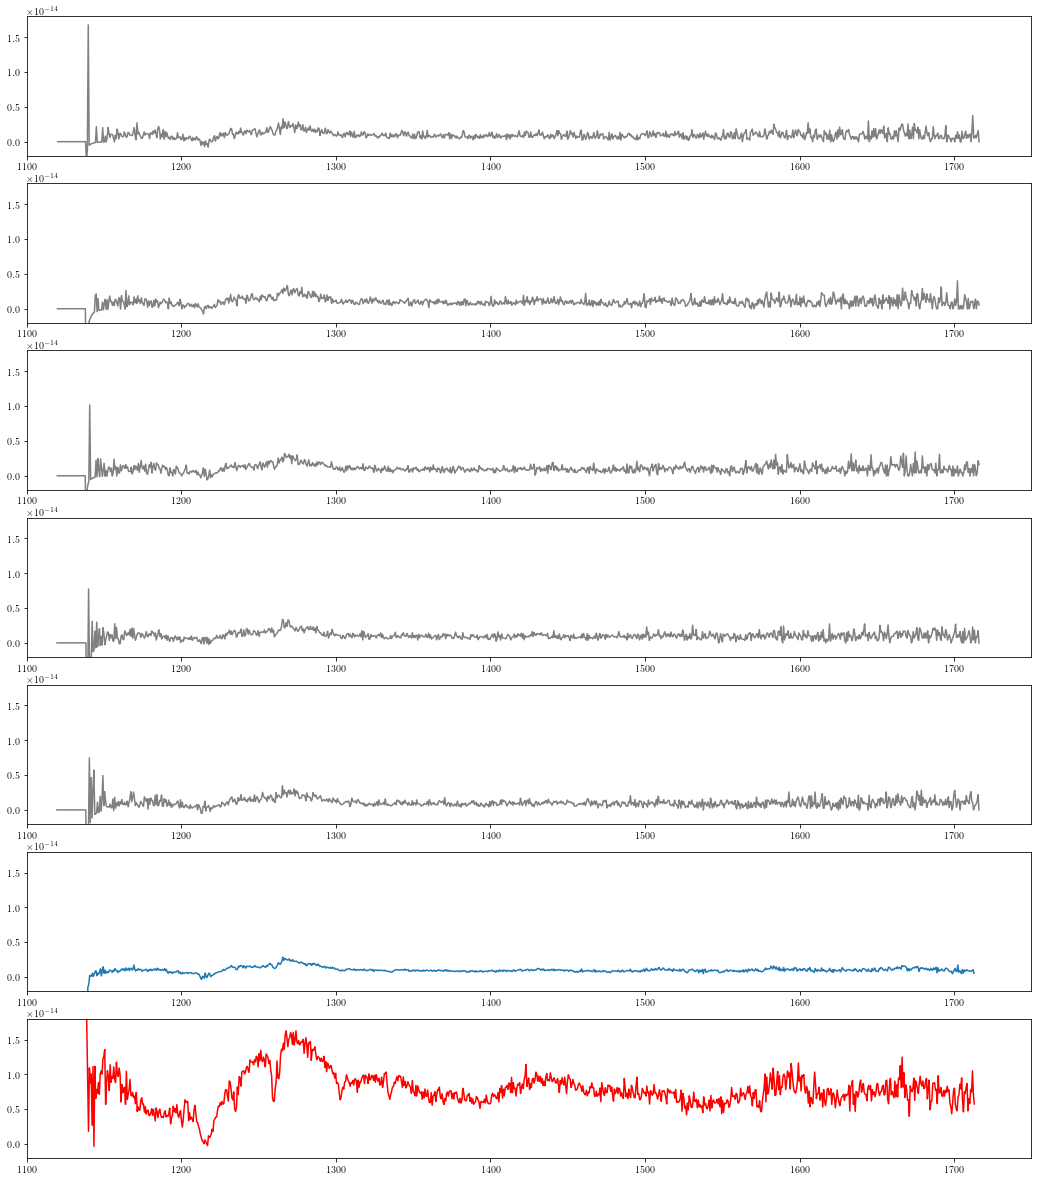

In [15]:
# 15

# Now let's compare the base-level constituent spectra
# with the overall program-level co-add.
#
# "tde"
#
# STIS G140L (3/3)

plt.figure(figsize=(18,21))

ax1 = plt.subplot(711)
ax2 = plt.subplot(712)
ax3 = plt.subplot(713)
ax4 = plt.subplot(714)
ax5 = plt.subplot(715)
ax6 = plt.subplot(716)
ax7 = plt.subplot(717)

table1 = fits.open(base_path+tde_STIS_G140L_base_file06)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1,color='grey')

table2 = fits.open(base_path+tde_STIS_G140L_base_file07)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2,color='grey')

table3 = fits.open(base_path+tde_STIS_G140L_base_file08)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3,color='grey')

table4 = fits.open(base_path+tde_STIS_G140L_base_file09)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4,color='grey')
    
table5 = fits.open(base_path+tde_STIS_G140L_base_file10)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5,color='grey')

table6 = fits.open(coadd_path+tde_STIS_G140L_const_file3)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6)

table7 = fits.open(coadd_path+tde_STIS_G140L_const_file)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7,color='red')

# Set appropriate scales.

ax1.set_xlim(1100, 1750)
ax1.set_ylim(-0.2e-14, 1.8e-14)

ax2.set_xlim(1100, 1750)
ax2.set_ylim(-0.2e-14, 1.8e-14)

ax3.set_xlim(1100, 1750)
ax3.set_ylim(-0.2e-14, 1.8e-14)

ax4.set_xlim(1100, 1750)
ax4.set_ylim(-0.2e-14, 1.8e-14)

ax5.set_xlim(1100, 1750)
ax5.set_ylim(-0.2e-14, 1.8e-14)

ax6.set_xlim(1100, 1750)
ax6.set_ylim(-0.2e-14, 1.8e-14)

ax7.set_xlim(1100, 1750)
ax7.set_ylim(-0.2e-14, 1.8e-14)


(-2e-15, 1.8e-14)

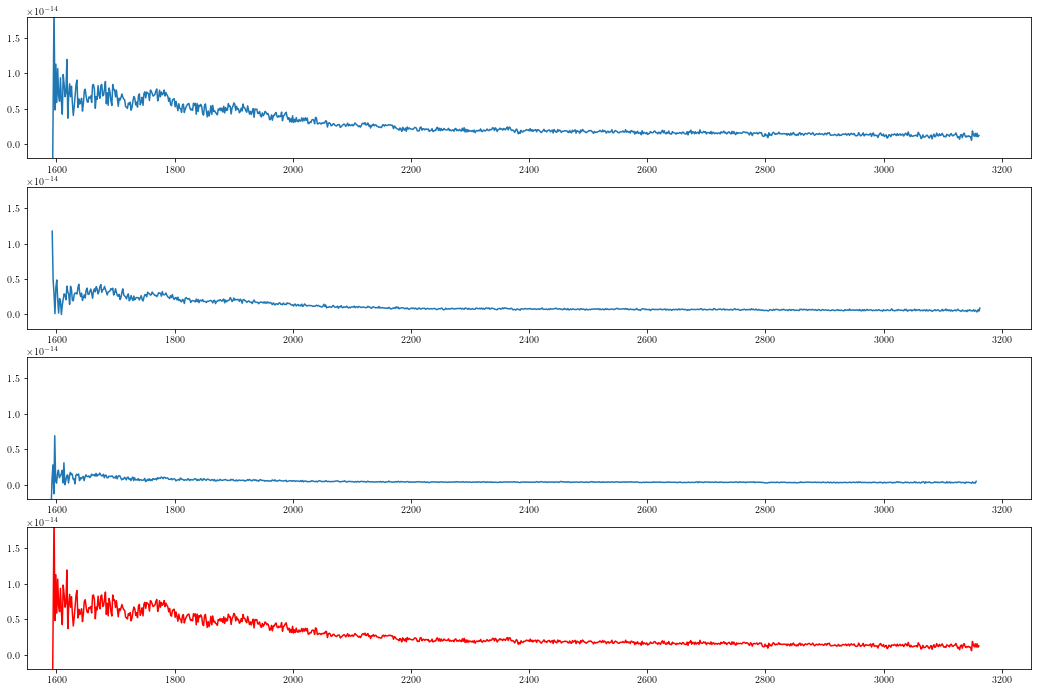

In [16]:
# 16

# "tde"

# STIS G230L

plt.figure(figsize=(18,12))

ax1 = plt.subplot(411)
ax2 = plt.subplot(412)
ax3 = plt.subplot(413)
ax4 = plt.subplot(414)

table1 = fits.open(coadd_path+tde_STIS_G230L_const_file1)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1)

table2 = fits.open(coadd_path+tde_STIS_G230L_const_file2)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2)

table3 = fits.open(coadd_path+tde_STIS_G230L_const_file3)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(coadd_path+tde_STIS_G230L_const_file)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4, color='red')
    
# Set appropriate scales.

ax1.set_xlim(1550, 3250)
ax1.set_ylim(-0.2e-14, 1.8e-14)

ax2.set_xlim(1550, 3250)
ax2.set_ylim(-0.2e-14, 1.8e-14)

ax3.set_xlim(1550, 3250)
ax3.set_ylim(-0.2e-14, 1.8e-14)

ax4.set_xlim(1550, 3250)
ax4.set_ylim(-0.2e-14, 1.8e-14)


(-2e-15, 1.8e-14)

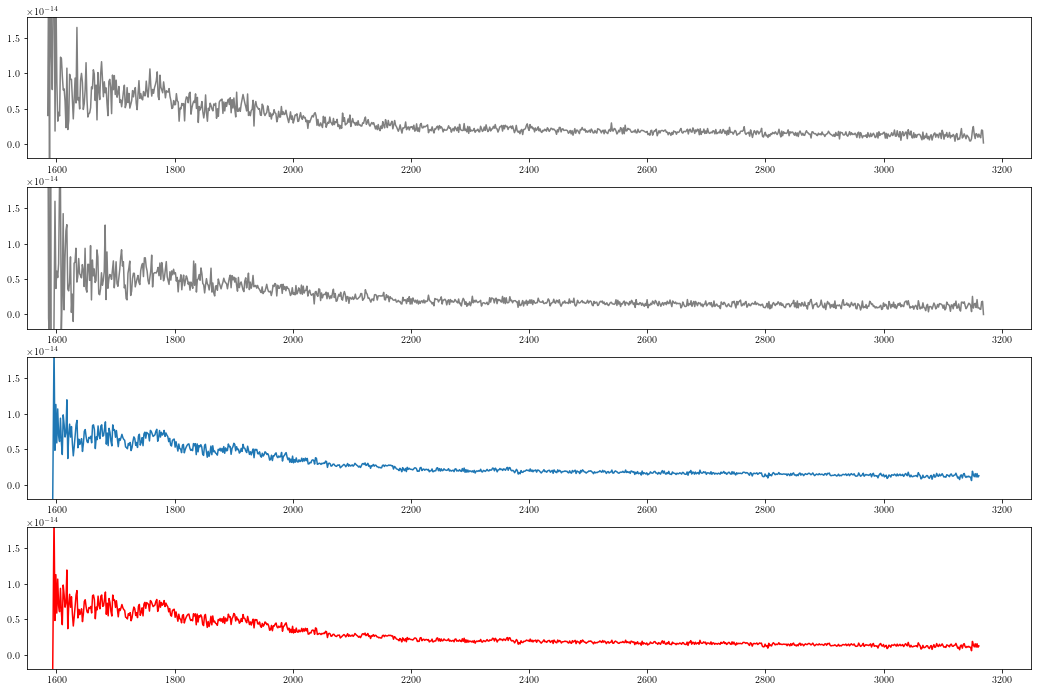

In [17]:
# 17

# Now let's compare the base-level constituent spectra
# with the overall program-level co-add.
#
# "tde"
#
# STIS G230L (1/3)

plt.figure(figsize=(18,12))

ax1 = plt.subplot(411)
ax2 = plt.subplot(412)
ax3 = plt.subplot(413)
ax4 = plt.subplot(414)

table1 = fits.open(base_path+tde_STIS_G230L_base_file01)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1,color='grey')

table2 = fits.open(base_path+tde_STIS_G230L_base_file02)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2,color='grey')

table3 = fits.open(coadd_path+tde_STIS_G230L_const_file1)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(coadd_path+tde_STIS_G230L_const_file)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4,color='red')

# Set appropriate scales.

ax1.set_xlim(1550, 3250)
ax1.set_ylim(-0.2e-14, 1.8e-14)

ax2.set_xlim(1550, 3250)
ax2.set_ylim(-0.2e-14, 1.8e-14)

ax3.set_xlim(1550, 3250)
ax3.set_ylim(-0.2e-14, 1.8e-14)

ax4.set_xlim(1550, 3250)
ax4.set_ylim(-0.2e-14, 1.8e-14)


(-2e-15, 1.8e-14)

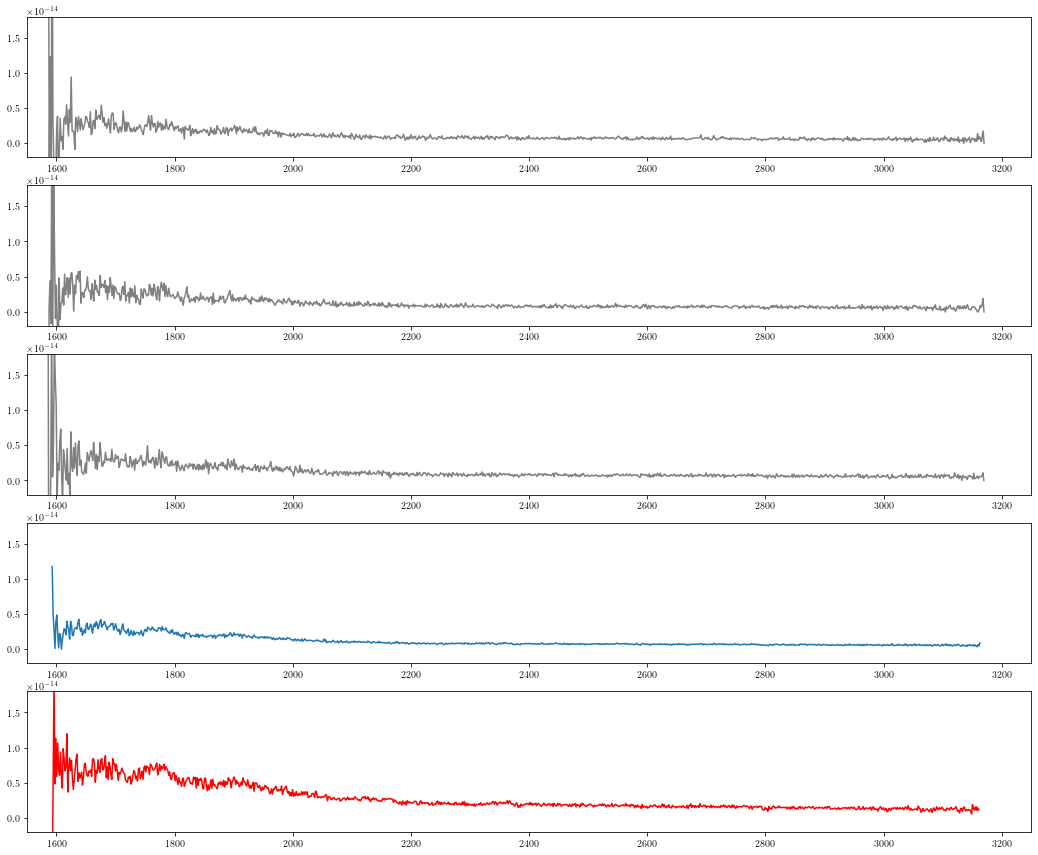

In [18]:
# 18

# Now let's compare the base-level constituent spectra
# with the overall program-level co-add.
#
# "tde"
#
# STIS G230L (2/3)

plt.figure(figsize=(18,15))

ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax5 = plt.subplot(515)

table1 = fits.open(base_path+tde_STIS_G230L_base_file03)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1,color='grey')

table2 = fits.open(base_path+tde_STIS_G230L_base_file04)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2,color='grey')

table3 = fits.open(base_path+tde_STIS_G230L_base_file05)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3,color='grey')

table4 = fits.open(coadd_path+tde_STIS_G230L_const_file2)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(coadd_path+tde_STIS_G230L_const_file)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5,color='red')

# Set appropriate scales.

ax1.set_xlim(1550, 3250)
ax1.set_ylim(-0.2e-14, 1.8e-14)

ax2.set_xlim(1550, 3250)
ax2.set_ylim(-0.2e-14, 1.8e-14)

ax3.set_xlim(1550, 3250)
ax3.set_ylim(-0.2e-14, 1.8e-14)

ax4.set_xlim(1550, 3250)
ax4.set_ylim(-0.2e-14, 1.8e-14)

ax5.set_xlim(1550, 3250)
ax5.set_ylim(-0.2e-14, 1.8e-14)


(-2e-15, 1.8e-14)

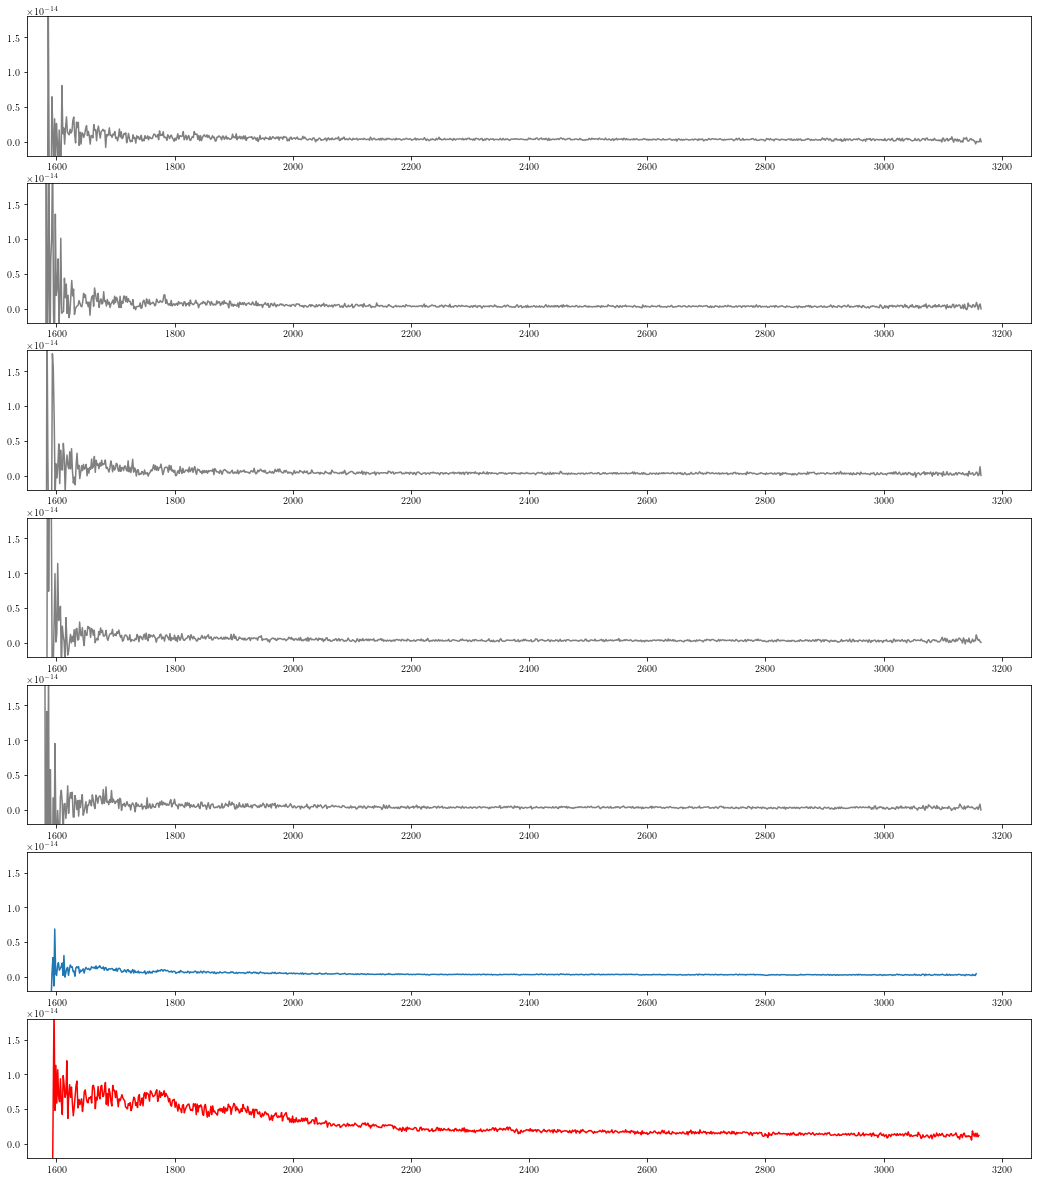

In [19]:
# 19

# Now let's compare the base-level constituent spectra
# with the overall program-level co-add.
#
# "tde"
#
# STIS G230L (3/3)

plt.figure(figsize=(18,21))

ax1 = plt.subplot(711)
ax2 = plt.subplot(712)
ax3 = plt.subplot(713)
ax4 = plt.subplot(714)
ax5 = plt.subplot(715)
ax6 = plt.subplot(716)
ax7 = plt.subplot(717)

table1 = fits.open(base_path+tde_STIS_G230L_base_file06)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1,color='grey')

table2 = fits.open(base_path+tde_STIS_G230L_base_file07)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2,color='grey')

table3 = fits.open(base_path+tde_STIS_G230L_base_file08)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3,color='grey')

table4 = fits.open(base_path+tde_STIS_G230L_base_file09)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4,color='grey')
    
table5 = fits.open(base_path+tde_STIS_G230L_base_file10)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5,color='grey')

table6 = fits.open(coadd_path+tde_STIS_G230L_const_file3)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6)

table7 = fits.open(coadd_path+tde_STIS_G230L_const_file)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7,color='red')

# Set appropriate scales.

ax1.set_xlim(1550, 3250)
ax1.set_ylim(-0.2e-14, 1.8e-14)

ax2.set_xlim(1550, 3250)
ax2.set_ylim(-0.2e-14, 1.8e-14)

ax3.set_xlim(1550, 3250)
ax3.set_ylim(-0.2e-14, 1.8e-14)

ax4.set_xlim(1550, 3250)
ax4.set_ylim(-0.2e-14, 1.8e-14)

ax5.set_xlim(1550, 3250)
ax5.set_ylim(-0.2e-14, 1.8e-14)

ax6.set_xlim(1550, 3250)
ax6.set_ylim(-0.2e-14, 1.8e-14)

ax7.set_xlim(1550, 3250)
ax7.set_ylim(-0.2e-14, 1.8e-14)


(-3e-15, 9e-15)

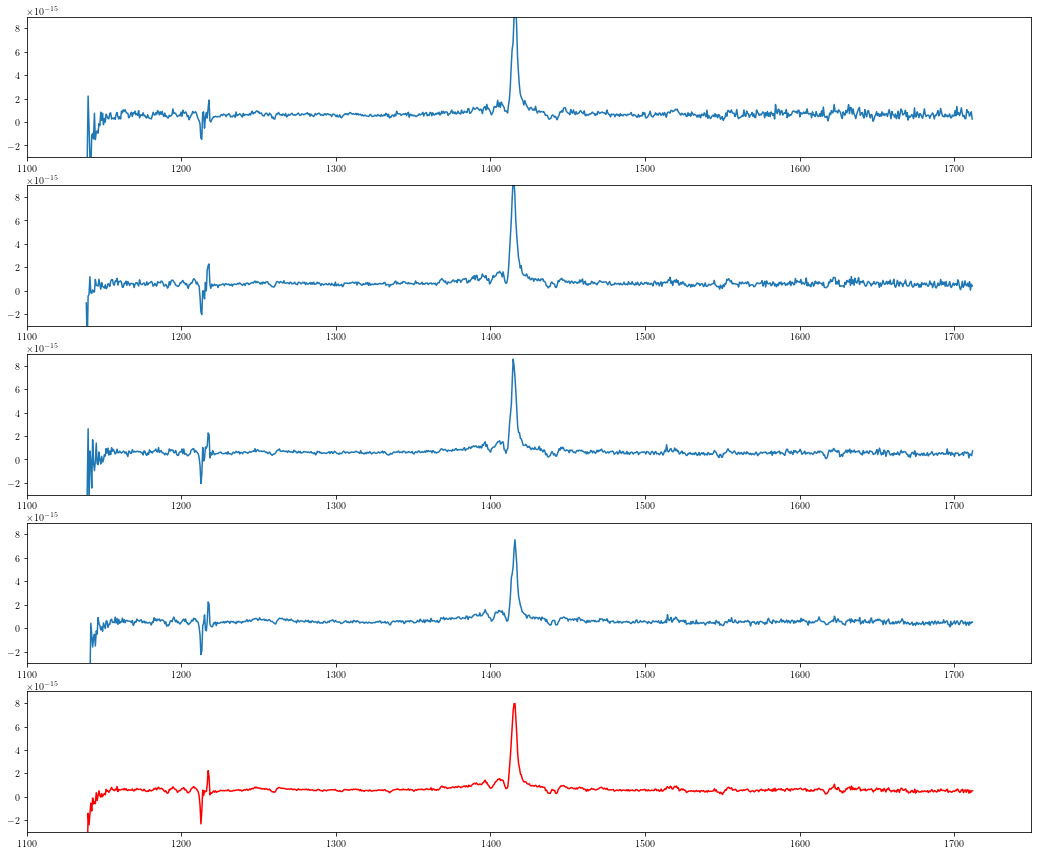

In [20]:
# 20

# Now let's do the same thing we just did with "tde" for "newtde".

# Let's plot the per-grating constituents and see how they compare
# with the overall per-grating and program-level co-adds.

# "newtde"

# STIS G140L

plt.figure(figsize=(18,15))

ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax5 = plt.subplot(515)

table1 = fits.open(coadd_path+newtde_STIS_G140L_const_file1)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1)

table2 = fits.open(coadd_path+newtde_STIS_G140L_const_file2)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2)

table3 = fits.open(coadd_path+newtde_STIS_G140L_const_file3)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(coadd_path+newtde_STIS_G140L_const_file4)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(coadd_path+newtde_STIS_G140L_const_file)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5, color='red')
    
# Set appropriate scales.

ax1.set_xlim(1100, 1750)
ax1.set_ylim(-3.0e-15, 9.0e-15)

ax2.set_xlim(1100, 1750)
ax2.set_ylim(-3.0e-15, 9.0e-15)

ax3.set_xlim(1100, 1750)
ax3.set_ylim(-3.0e-15, 9.0e-15)

ax4.set_xlim(1100, 1750)
ax4.set_ylim(-3.0e-15, 9.0e-15)

ax5.set_xlim(1100, 1750)
ax5.set_ylim(-3.0e-15, 9.0e-15)


(-3e-15, 9e-15)

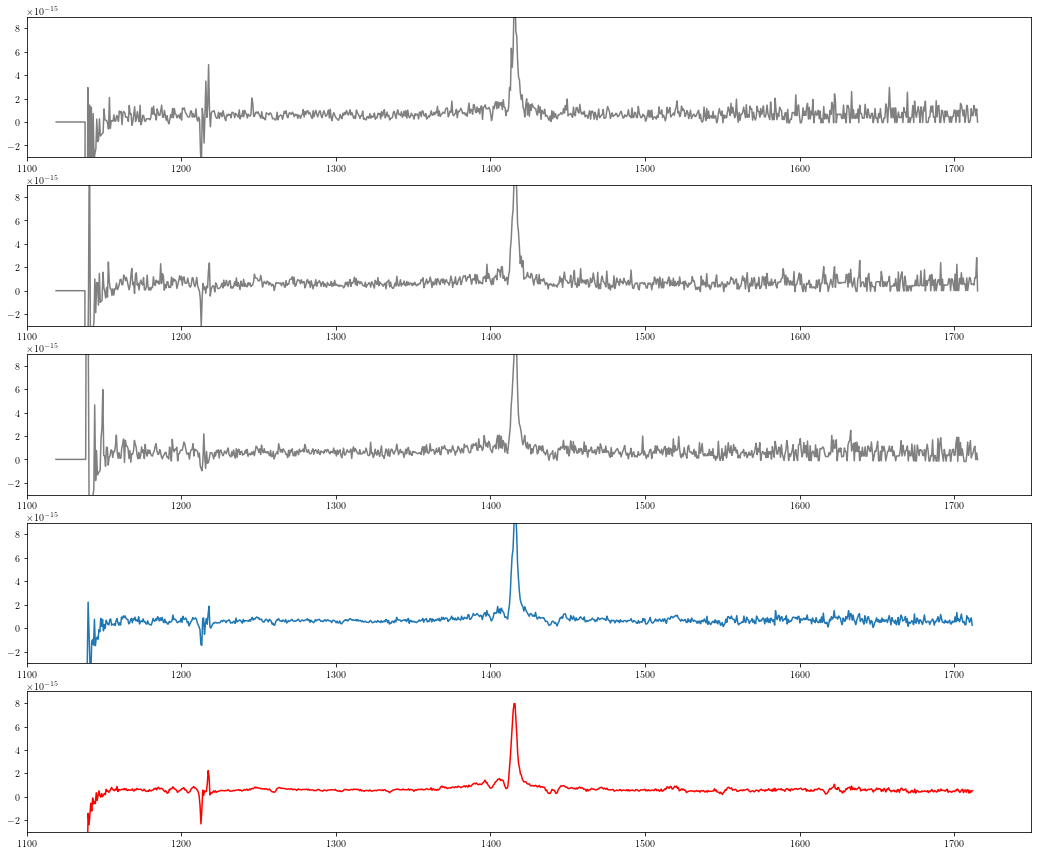

In [21]:
# 21

# Now let's compare the base-level constituent spectra
# with the overall program-level co-add.
#
# "newtde"
#
# STIS G140L (1/4)

plt.figure(figsize=(18,15))

ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax5 = plt.subplot(515)

table1 = fits.open(base_path+newtde_STIS_G140L_base_file01)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1,color='grey')

table2 = fits.open(base_path+newtde_STIS_G140L_base_file02)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2,color='grey')

table3 = fits.open(base_path+newtde_STIS_G140L_base_file03)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3,color='grey')

table4 = fits.open(coadd_path+newtde_STIS_G140L_const_file1)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(coadd_path+newtde_STIS_G140L_const_file)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5,color='red')

# Set appropriate scales.

ax1.set_xlim(1100, 1750)
ax1.set_ylim(-3.0e-15, 9.0e-15)

ax2.set_xlim(1100, 1750)
ax2.set_ylim(-3.0e-15, 9.0e-15)

ax3.set_xlim(1100, 1750)
ax3.set_ylim(-3.0e-15, 9.0e-15)

ax4.set_xlim(1100, 1750)
ax4.set_ylim(-3.0e-15, 9.0e-15)

ax5.set_xlim(1100, 1750)
ax5.set_ylim(-3.0e-15, 9.0e-15)


(-3e-15, 9e-15)

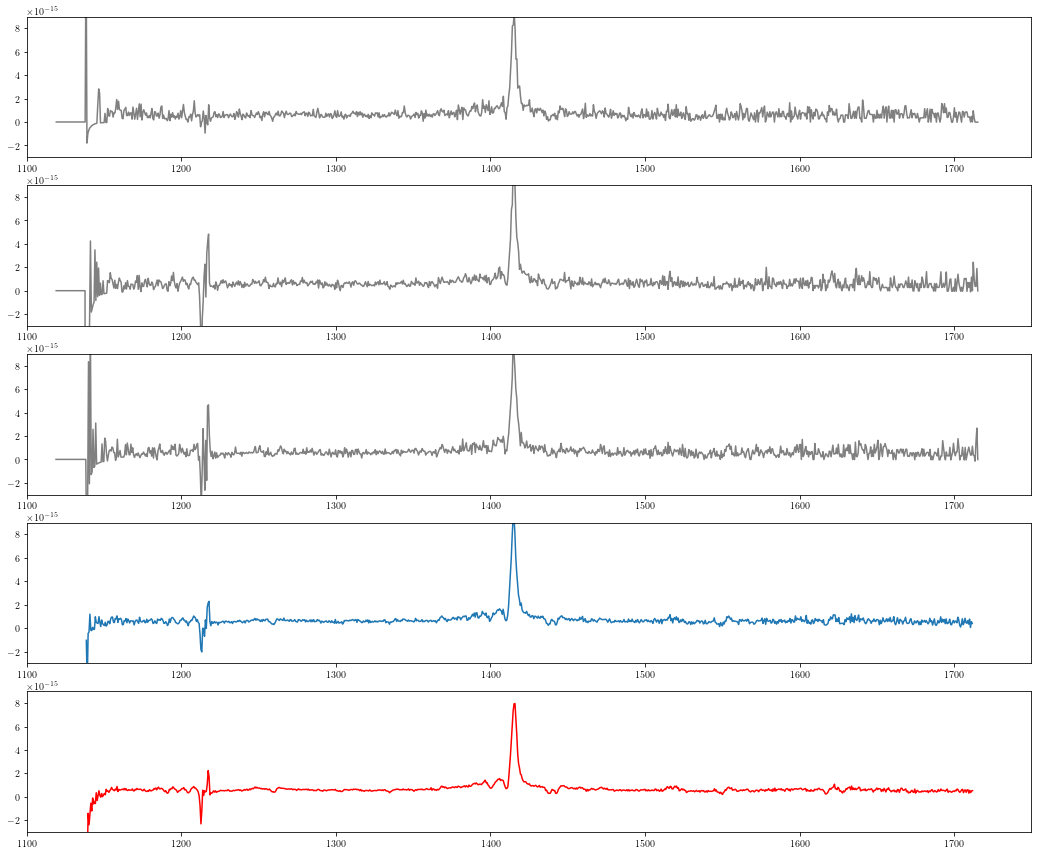

In [22]:
# 22

# Now let's compare the base-level constituent spectra
# with the overall program-level co-add.
#
# "newtde"
#
# STIS G140L (2/4)

plt.figure(figsize=(18,15))

ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax5 = plt.subplot(515)

table1 = fits.open(base_path+newtde_STIS_G140L_base_file04)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1,color='grey')

table2 = fits.open(base_path+newtde_STIS_G140L_base_file05)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2,color='grey')

table3 = fits.open(base_path+newtde_STIS_G140L_base_file06)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3,color='grey')

table4 = fits.open(coadd_path+newtde_STIS_G140L_const_file2)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(coadd_path+newtde_STIS_G140L_const_file)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5,color='red')

# Set appropriate scales.

ax1.set_xlim(1100, 1750)
ax1.set_ylim(-3.0e-15, 9.0e-15)

ax2.set_xlim(1100, 1750)
ax2.set_ylim(-3.0e-15, 9.0e-15)

ax3.set_xlim(1100, 1750)
ax3.set_ylim(-3.0e-15, 9.0e-15)

ax4.set_xlim(1100, 1750)
ax4.set_ylim(-3.0e-15, 9.0e-15)

ax5.set_xlim(1100, 1750)
ax5.set_ylim(-3.0e-15, 9.0e-15)


(-3e-15, 9e-15)

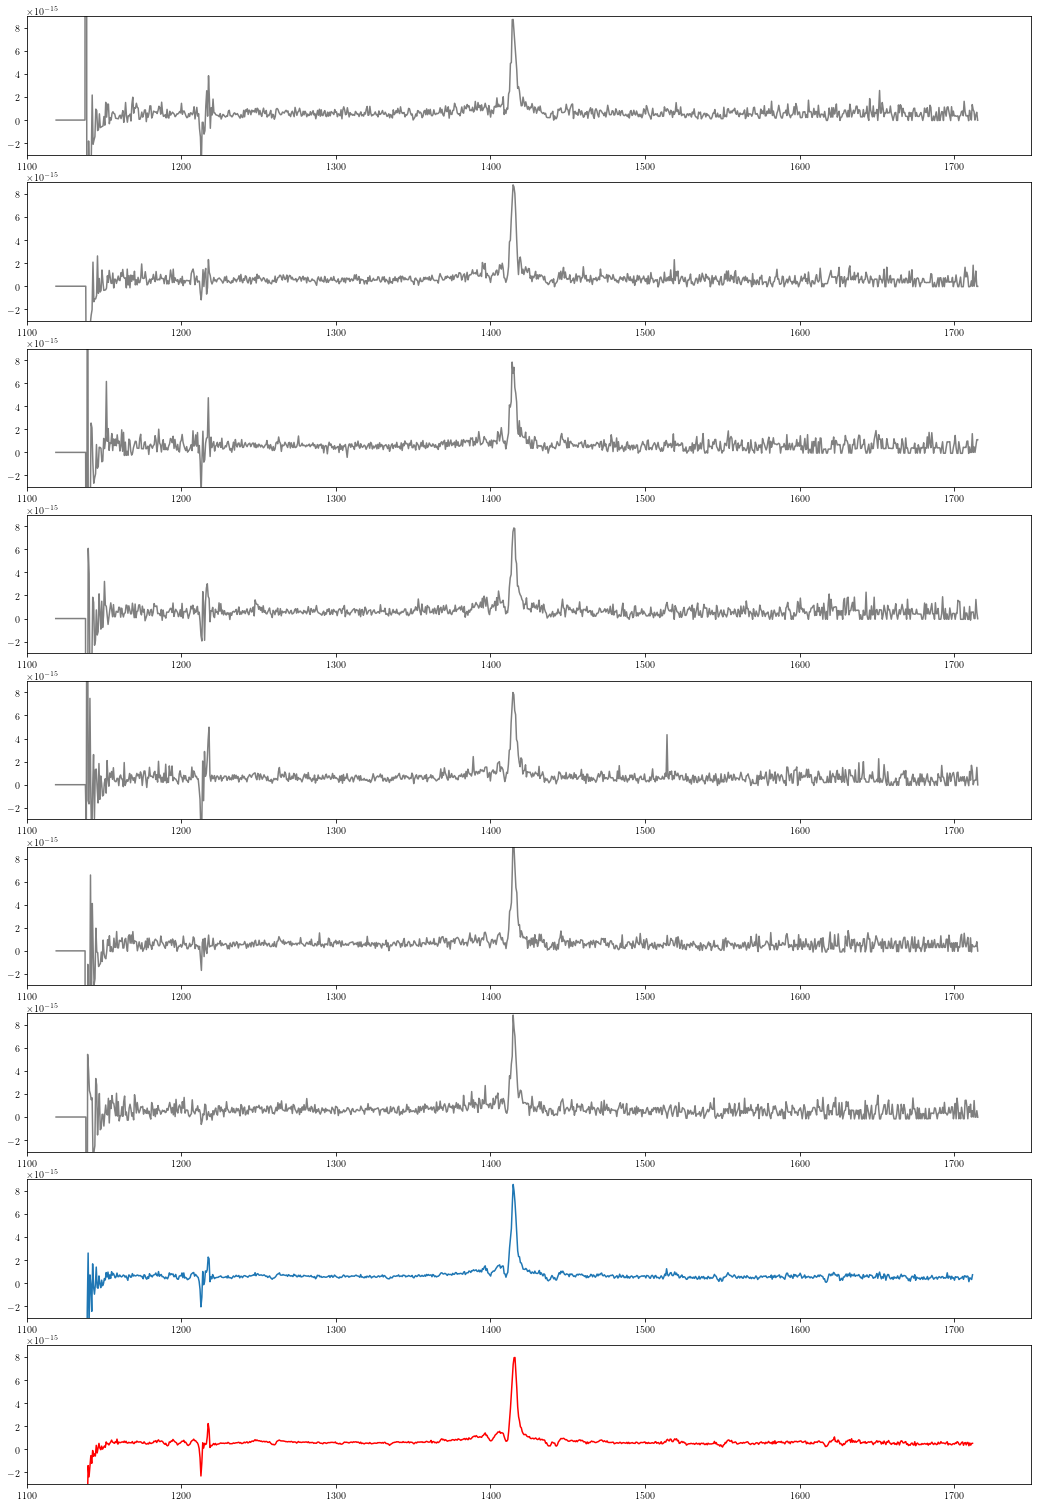

In [23]:
# 23

# Now let's compare the base-level constituent spectra
# with the overall program-level co-add.
#
# "newtde"
#
# STIS G140L (3/4)

plt.figure(figsize=(18,27))

ax1 = plt.subplot(911)
ax2 = plt.subplot(912)
ax3 = plt.subplot(913)
ax4 = plt.subplot(914)
ax5 = plt.subplot(915)
ax6 = plt.subplot(916)
ax7 = plt.subplot(917)
ax8 = plt.subplot(918)
ax9 = plt.subplot(919)

table1 = fits.open(base_path+newtde_STIS_G140L_base_file07)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1,color='grey')

table2 = fits.open(base_path+newtde_STIS_G140L_base_file08)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2,color='grey')

table3 = fits.open(base_path+newtde_STIS_G140L_base_file09)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3,color='grey')

table4 = fits.open(base_path+newtde_STIS_G140L_base_file10)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4,color='grey')
    
table5 = fits.open(base_path+newtde_STIS_G140L_base_file11)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5,color='grey')

table6 = fits.open(base_path+newtde_STIS_G140L_base_file12)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6,color='grey')
    
table7 = fits.open(base_path+newtde_STIS_G140L_base_file13)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7,color='grey')

table8 = fits.open(coadd_path+newtde_STIS_G140L_const_file3)[1].data
for row in table8:
    wave8 = row['wavelength']
    flux8 = row['flux']
    ax8.plot(wave8,flux8)

table9 = fits.open(coadd_path+newtde_STIS_G140L_const_file)[1].data
for row in table9:
    wave9 = row['wavelength']
    flux9 = row['flux']
    ax9.plot(wave9,flux9,color='red')

# Set appropriate scales.

ax1.set_xlim(1100, 1750)
ax1.set_ylim(-3.0e-15, 9.0e-15)

ax2.set_xlim(1100, 1750)
ax2.set_ylim(-3.0e-15, 9.0e-15)

ax3.set_xlim(1100, 1750)
ax3.set_ylim(-3.0e-15, 9.0e-15)

ax4.set_xlim(1100, 1750)
ax4.set_ylim(-3.0e-15, 9.0e-15)

ax5.set_xlim(1100, 1750)
ax5.set_ylim(-3.0e-15, 9.0e-15)

ax6.set_xlim(1100, 1750)
ax6.set_ylim(-3.0e-15, 9.0e-15)

ax7.set_xlim(1100, 1750)
ax7.set_ylim(-3.0e-15, 9.0e-15)

ax8.set_xlim(1100, 1750)
ax8.set_ylim(-3.0e-15, 9.0e-15)

ax9.set_xlim(1100, 1750)
ax9.set_ylim(-3.0e-15, 9.0e-15)


(-3e-15, 9e-15)

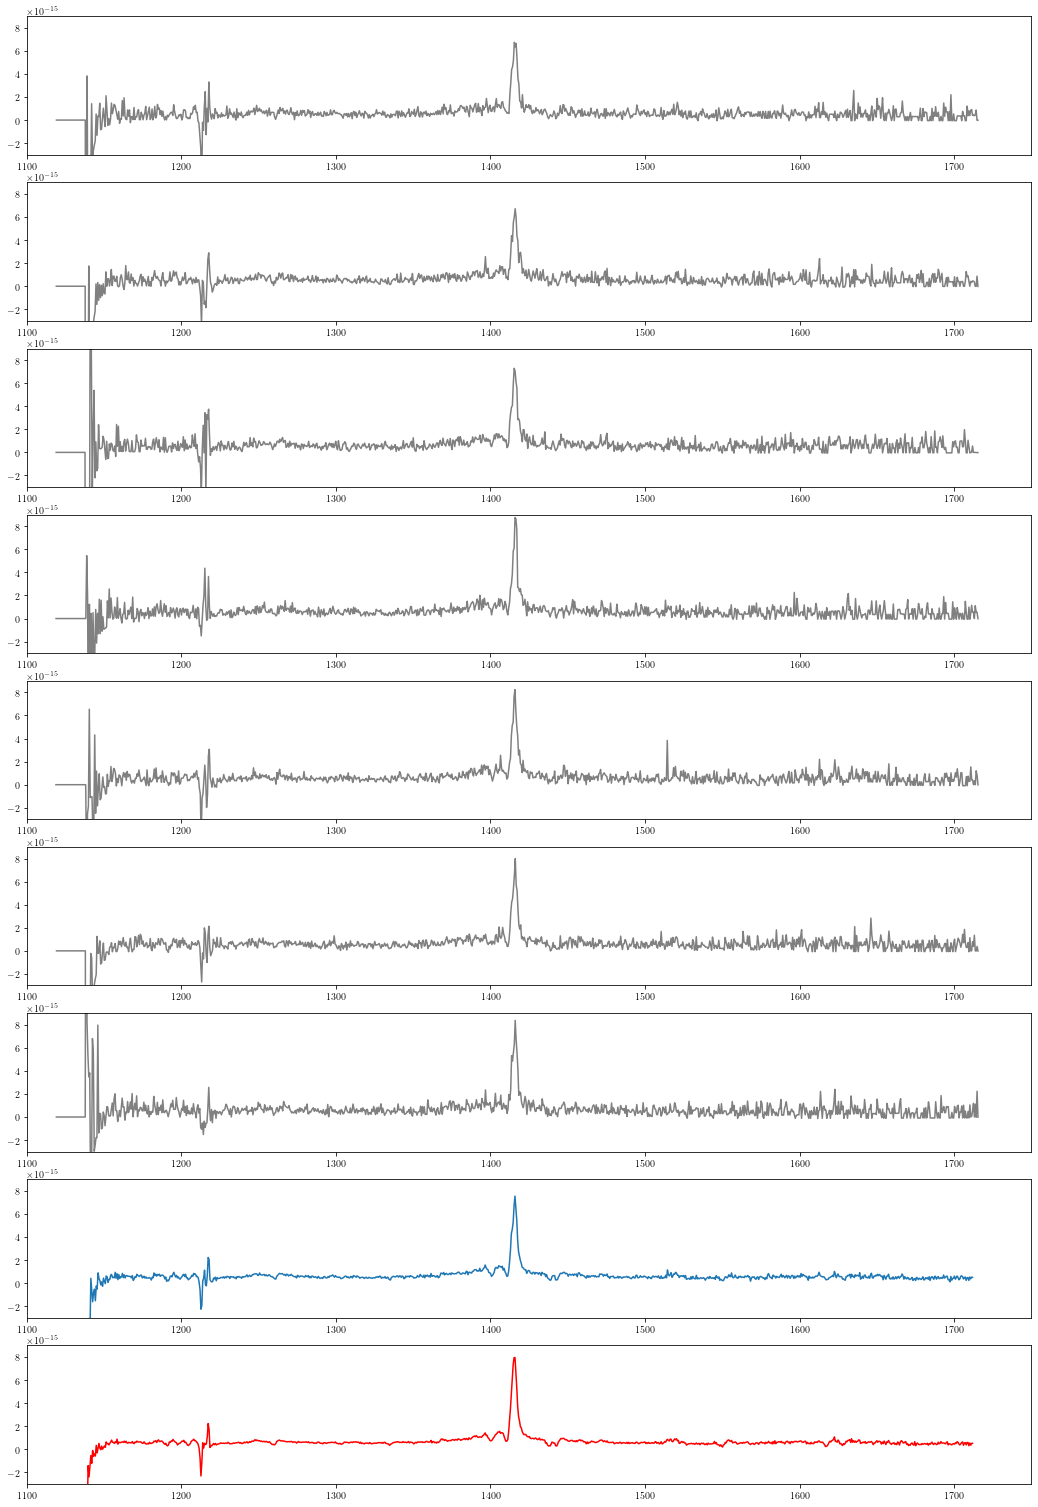

In [24]:
# 24

# Now let's compare the base-level constituent spectra
# with the overall program-level co-add.
#
# "newtde"
#
# STIS G140L (4/4)

plt.figure(figsize=(18,27))

ax1 = plt.subplot(911)
ax2 = plt.subplot(912)
ax3 = plt.subplot(913)
ax4 = plt.subplot(914)
ax5 = plt.subplot(915)
ax6 = plt.subplot(916)
ax7 = plt.subplot(917)
ax8 = plt.subplot(918)
ax9 = plt.subplot(919)

table1 = fits.open(base_path+newtde_STIS_G140L_base_file14)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1,color='grey')

table2 = fits.open(base_path+newtde_STIS_G140L_base_file15)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2,color='grey')

table3 = fits.open(base_path+newtde_STIS_G140L_base_file16)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3,color='grey')

table4 = fits.open(base_path+newtde_STIS_G140L_base_file17)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4,color='grey')
    
table5 = fits.open(base_path+newtde_STIS_G140L_base_file18)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5,color='grey')

table6 = fits.open(base_path+newtde_STIS_G140L_base_file19)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6,color='grey')
    
table7 = fits.open(base_path+newtde_STIS_G140L_base_file20)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7,color='grey')

table8 = fits.open(coadd_path+newtde_STIS_G140L_const_file4)[1].data
for row in table8:
    wave8 = row['wavelength']
    flux8 = row['flux']
    ax8.plot(wave8,flux8)

table9 = fits.open(coadd_path+newtde_STIS_G140L_const_file)[1].data
for row in table9:
    wave9 = row['wavelength']
    flux9 = row['flux']
    ax9.plot(wave9,flux9,color='red')

# Set appropriate scales.

ax1.set_xlim(1100, 1750)
ax1.set_ylim(-3.0e-15, 9.0e-15)

ax2.set_xlim(1100, 1750)
ax2.set_ylim(-3.0e-15, 9.0e-15)

ax3.set_xlim(1100, 1750)
ax3.set_ylim(-3.0e-15, 9.0e-15)

ax4.set_xlim(1100, 1750)
ax4.set_ylim(-3.0e-15, 9.0e-15)

ax5.set_xlim(1100, 1750)
ax5.set_ylim(-3.0e-15, 9.0e-15)

ax6.set_xlim(1100, 1750)
ax6.set_ylim(-3.0e-15, 9.0e-15)

ax7.set_xlim(1100, 1750)
ax7.set_ylim(-3.0e-15, 9.0e-15)

ax8.set_xlim(1100, 1750)
ax8.set_ylim(-3.0e-15, 9.0e-15)

ax9.set_xlim(1100, 1750)
ax9.set_ylim(-3.0e-15, 9.0e-15)


(-3e-15, 9e-15)

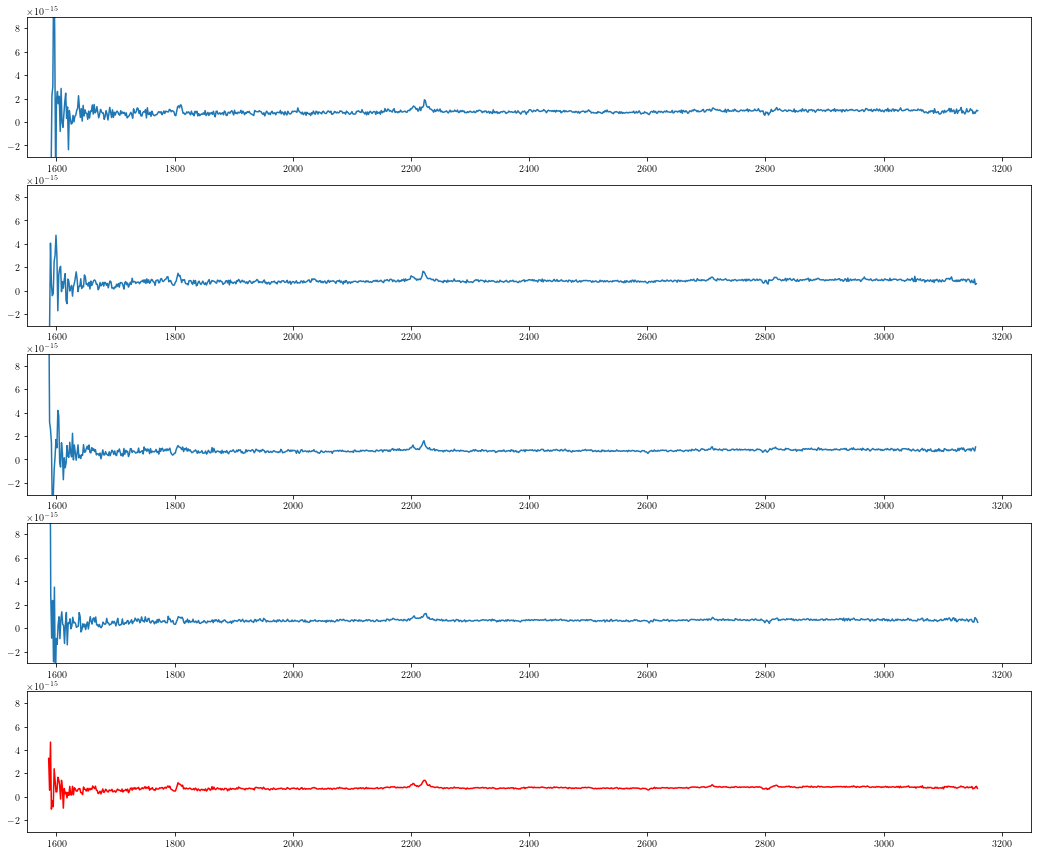

In [25]:
# 25

# "newtde"

# STIS G230L

plt.figure(figsize=(18,15))

ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax5 = plt.subplot(515)

table1 = fits.open(coadd_path+newtde_STIS_G230L_const_file1)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1)

table2 = fits.open(coadd_path+newtde_STIS_G230L_const_file2)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2)

table3 = fits.open(coadd_path+newtde_STIS_G230L_const_file3)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(coadd_path+newtde_STIS_G230L_const_file4)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(coadd_path+newtde_STIS_G230L_const_file)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5, color='red')
    
# Set appropriate scales.

ax1.set_xlim(1550, 3250)
ax1.set_ylim(-3.0e-15, 9.0e-15)

ax2.set_xlim(1550, 3250)
ax2.set_ylim(-3.0e-15, 9.0e-15)

ax3.set_xlim(1550, 3250)
ax3.set_ylim(-3.0e-15, 9.0e-15)

ax4.set_xlim(1550, 3250)
ax4.set_ylim(-3.0e-15, 9.0e-15)

ax5.set_xlim(1550, 3250)
#ax5.set_ylim(-0.2e-14, 1.8e-14)
ax5.set_ylim(-3.0e-15, 9.0e-15)


(-3e-15, 9e-15)

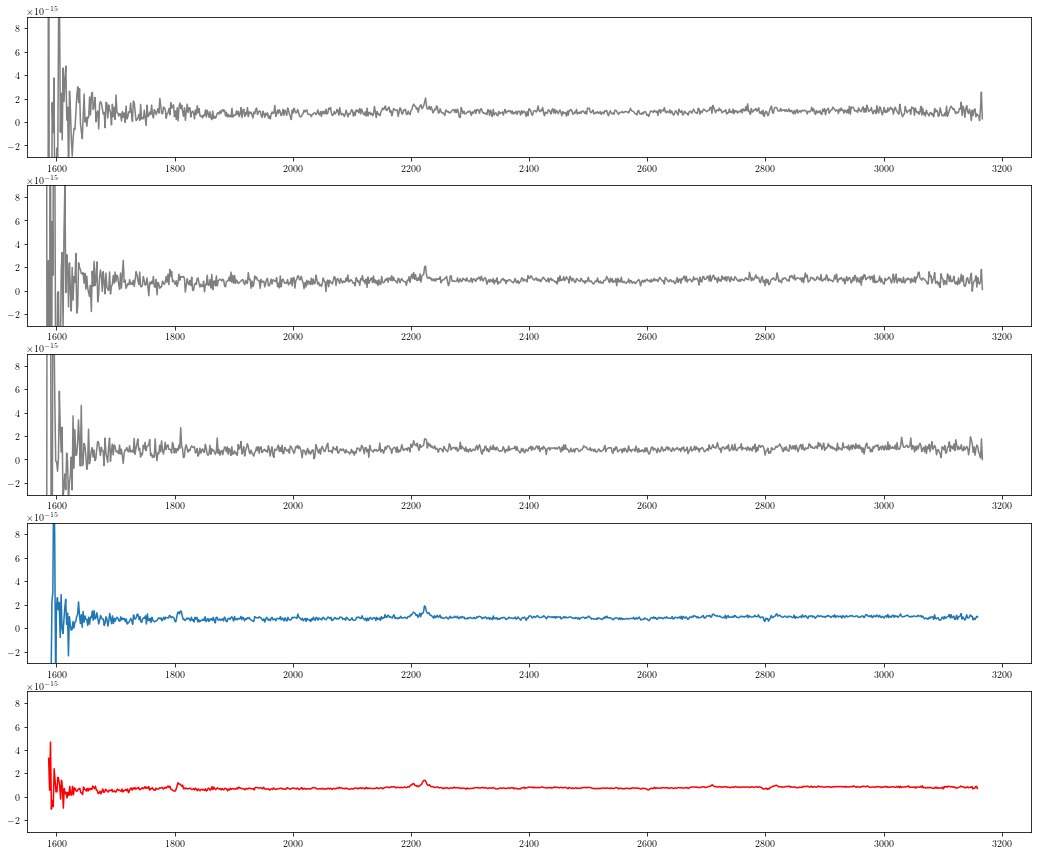

In [26]:
# 26

# Now let's compare the base-level constituent spectra
# with the overall program-level co-add.
#
# "newtde"
#
# STIS G230L (1/4)

plt.figure(figsize=(18,15))

ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax5 = plt.subplot(515)

table1 = fits.open(base_path+newtde_STIS_G230L_base_file01)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1,color='grey')

table2 = fits.open(base_path+newtde_STIS_G230L_base_file02)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2,color='grey')

table3 = fits.open(base_path+newtde_STIS_G230L_base_file03)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3,color='grey')

table4 = fits.open(coadd_path+newtde_STIS_G230L_const_file1)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(coadd_path+newtde_STIS_G230L_const_file)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5,color='red')

# Set appropriate scales.

ax1.set_xlim(1550, 3250)
ax1.set_ylim(-3.0e-15, 9.0e-15)

ax2.set_xlim(1550, 3250)
ax2.set_ylim(-3.0e-15, 9.0e-15)

ax3.set_xlim(1550, 3250)
ax3.set_ylim(-3.0e-15, 9.0e-15)

ax4.set_xlim(1550, 3250)
ax4.set_ylim(-3.0e-15, 9.0e-15)

ax5.set_xlim(1550, 3250)
ax5.set_ylim(-3.0e-15, 9.0e-15)


(-3e-15, 9e-15)

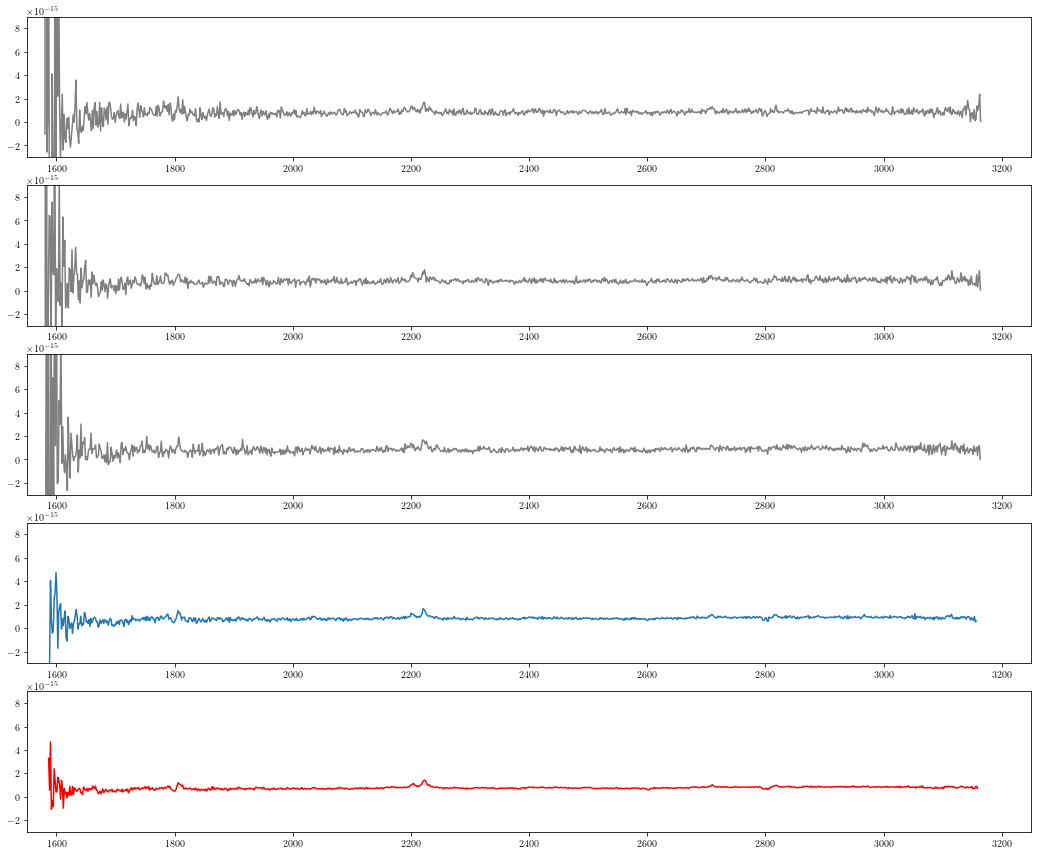

In [27]:
# 27

# Now let's compare the base-level constituent spectra
# with the overall program-level co-add.
#
# "newtde"
#
# STIS G230L (2/4)

plt.figure(figsize=(18,15))

ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax5 = plt.subplot(515)

table1 = fits.open(base_path+newtde_STIS_G230L_base_file04)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1,color='grey')

table2 = fits.open(base_path+newtde_STIS_G230L_base_file05)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2,color='grey')

table3 = fits.open(base_path+newtde_STIS_G230L_base_file06)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3,color='grey')

table4 = fits.open(coadd_path+newtde_STIS_G230L_const_file2)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(coadd_path+newtde_STIS_G230L_const_file)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5,color='red')

# Set appropriate scales.

ax1.set_xlim(1550, 3250)
ax1.set_ylim(-3.0e-15, 9.0e-15)

ax2.set_xlim(1550, 3250)
ax2.set_ylim(-3.0e-15, 9.0e-15)

ax3.set_xlim(1550, 3250)
ax3.set_ylim(-3.0e-15, 9.0e-15)

ax4.set_xlim(1550, 3250)
ax4.set_ylim(-3.0e-15, 9.0e-15)

ax5.set_xlim(1550, 3250)
ax5.set_ylim(-3.0e-15, 9.0e-15)


(-3e-15, 9e-15)

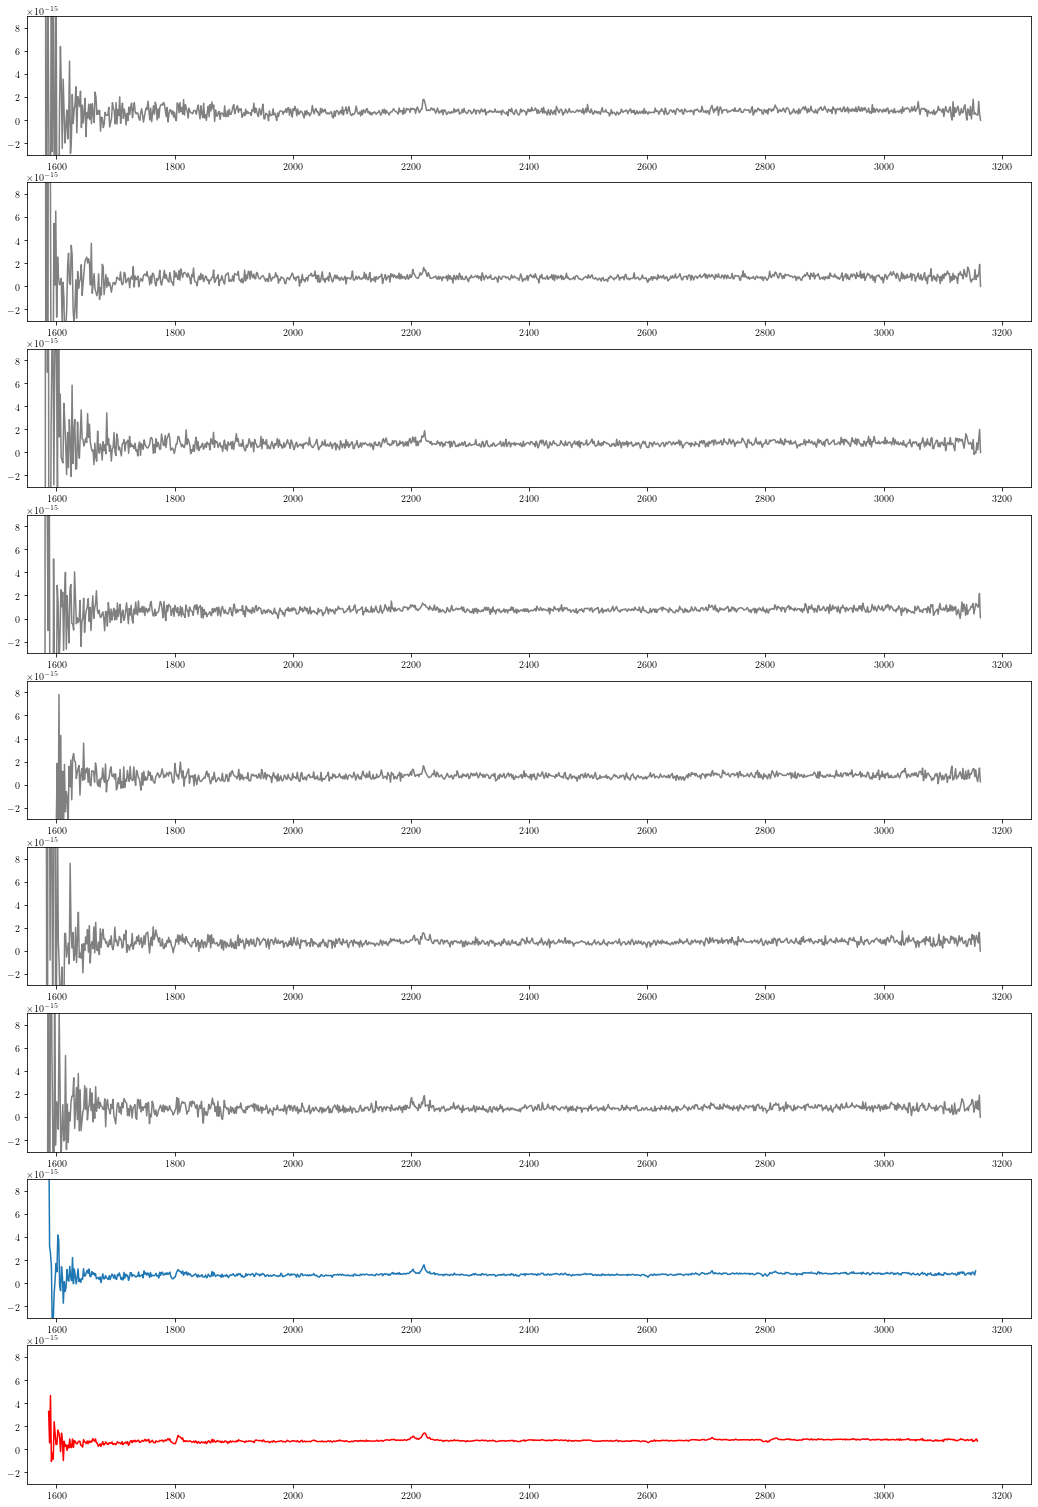

In [28]:
# 28

# Now let's compare the base-level constituent spectra
# with the overall program-level co-add.
#
# "newtde"
#
# STIS G230L (3/4)

plt.figure(figsize=(18,27))

ax1 = plt.subplot(911)
ax2 = plt.subplot(912)
ax3 = plt.subplot(913)
ax4 = plt.subplot(914)
ax5 = plt.subplot(915)
ax6 = plt.subplot(916)
ax7 = plt.subplot(917)
ax8 = plt.subplot(918)
ax9 = plt.subplot(919)

table1 = fits.open(base_path+newtde_STIS_G230L_base_file07)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1,color='grey')

table2 = fits.open(base_path+newtde_STIS_G230L_base_file08)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2,color='grey')

table3 = fits.open(base_path+newtde_STIS_G230L_base_file09)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3,color='grey')

table4 = fits.open(base_path+newtde_STIS_G230L_base_file10)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4,color='grey')
    
table5 = fits.open(base_path+newtde_STIS_G230L_base_file11)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5,color='grey')

table6 = fits.open(base_path+newtde_STIS_G230L_base_file12)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6,color='grey')
    
table7 = fits.open(base_path+newtde_STIS_G230L_base_file13)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7,color='grey')

table8 = fits.open(coadd_path+newtde_STIS_G230L_const_file3)[1].data
for row in table8:
    wave8 = row['wavelength']
    flux8 = row['flux']
    ax8.plot(wave8,flux8)

table9 = fits.open(coadd_path+newtde_STIS_G230L_const_file)[1].data
for row in table9:
    wave9 = row['wavelength']
    flux9 = row['flux']
    ax9.plot(wave9,flux9,color='red')

# Set appropriate scales.

ax1.set_xlim(1550, 3250)
ax1.set_ylim(-3.0e-15, 9.0e-15)

ax2.set_xlim(1550, 3250)
ax2.set_ylim(-3.0e-15, 9.0e-15)

ax3.set_xlim(1550, 3250)
ax3.set_ylim(-3.0e-15, 9.0e-15)

ax4.set_xlim(1550, 3250)
ax4.set_ylim(-3.0e-15, 9.0e-15)

ax5.set_xlim(1550, 3250)
ax5.set_ylim(-3.0e-15, 9.0e-15)

ax6.set_xlim(1550, 3250)
ax6.set_ylim(-3.0e-15, 9.0e-15)

ax7.set_xlim(1550, 3250)
ax7.set_ylim(-3.0e-15, 9.0e-15)

ax8.set_xlim(1550, 3250)
ax8.set_ylim(-3.0e-15, 9.0e-15)

ax9.set_xlim(1550, 3250)
ax9.set_ylim(-3.0e-15, 9.0e-15)


(-3e-15, 9e-15)

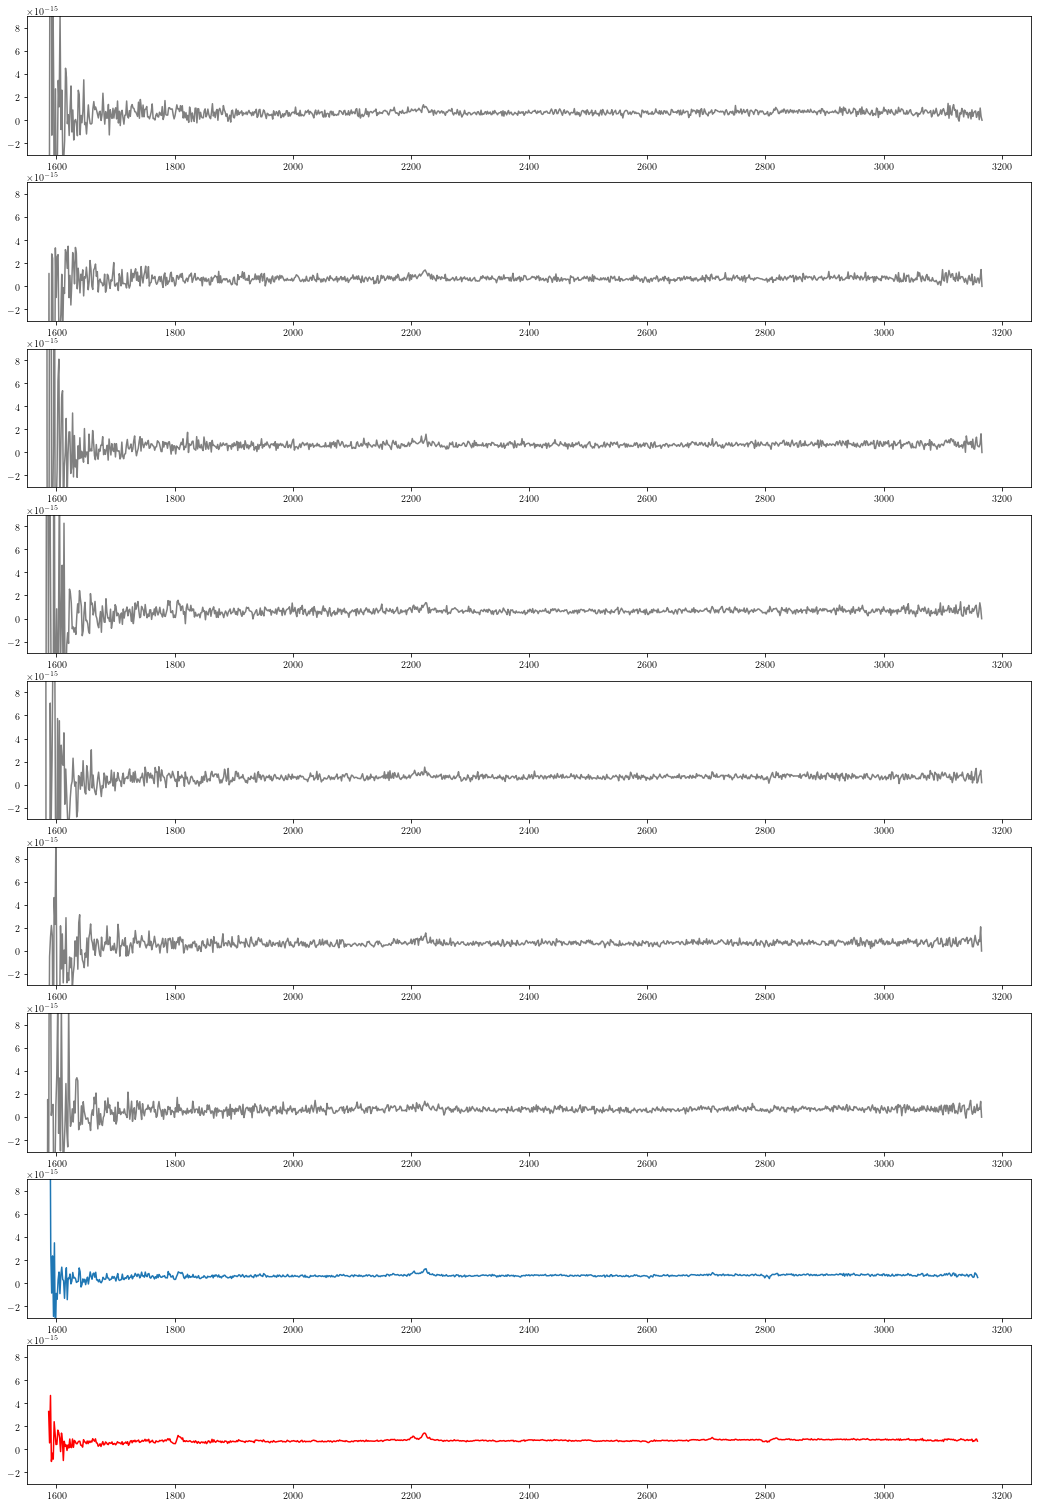

In [29]:
# 29

# Now let's compare the base-level constituent spectra
# with the overall program-level co-add.
#
# "newtde"
#
# STIS G230L (4/4)

plt.figure(figsize=(18,27))

ax1 = plt.subplot(911)
ax2 = plt.subplot(912)
ax3 = plt.subplot(913)
ax4 = plt.subplot(914)
ax5 = plt.subplot(915)
ax6 = plt.subplot(916)
ax7 = plt.subplot(917)
ax8 = plt.subplot(918)
ax9 = plt.subplot(919)

table1 = fits.open(base_path+newtde_STIS_G230L_base_file14)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1,color='grey')

table2 = fits.open(base_path+newtde_STIS_G230L_base_file15)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2,color='grey')

table3 = fits.open(base_path+newtde_STIS_G230L_base_file16)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3,color='grey')

table4 = fits.open(base_path+newtde_STIS_G230L_base_file17)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4,color='grey')
    
table5 = fits.open(base_path+newtde_STIS_G230L_base_file18)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5,color='grey')

table6 = fits.open(base_path+newtde_STIS_G230L_base_file19)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6,color='grey')
    
table7 = fits.open(base_path+newtde_STIS_G230L_base_file20)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7,color='grey')

table8 = fits.open(coadd_path+newtde_STIS_G230L_const_file4)[1].data
for row in table8:
    wave8 = row['wavelength']
    flux8 = row['flux']
    ax8.plot(wave8,flux8)

table9 = fits.open(coadd_path+newtde_STIS_G230L_const_file)[1].data
for row in table9:
    wave9 = row['wavelength']
    flux9 = row['flux']
    ax9.plot(wave9,flux9,color='red')

# Set appropriate scales.

ax1.set_xlim(1550, 3250)
ax1.set_ylim(-3.0e-15, 9.0e-15)

ax2.set_xlim(1550, 3250)
ax2.set_ylim(-3.0e-15, 9.0e-15)

ax3.set_xlim(1550, 3250)
ax3.set_ylim(-3.0e-15, 9.0e-15)

ax4.set_xlim(1550, 3250)
ax4.set_ylim(-3.0e-15, 9.0e-15)

ax5.set_xlim(1550, 3250)
ax5.set_ylim(-3.0e-15, 9.0e-15)

ax6.set_xlim(1550, 3250)
ax6.set_ylim(-3.0e-15, 9.0e-15)

ax7.set_xlim(1550, 3250)
ax7.set_ylim(-3.0e-15, 9.0e-15)

ax8.set_xlim(1550, 3250)
ax8.set_ylim(-3.0e-15, 9.0e-15)

ax9.set_xlim(1550, 3250)
ax9.set_ylim(-3.0e-15, 9.0e-15)
